# Projet HAI817 – Classification SciTweets avec Naïve Bayes

In [1]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install sklearn
%pip install scikit-learn
%pip install nltk
%pip install wordcloud
%pip install emoji


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:


## Dataset Loading and Initial Exploration
First, we'll load the dataset and take a look at its structure and basic statistics.

In [2]:
import pandas as pd
df = pd.read_csv("scitweets_export.tsv", sep="\t")
df.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


In [3]:
# Check dataset shape and information
print(f"Dataset shape: {df.shape}")
print("\nColumn information:")
df.info()

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Display basic statistics
print("\nBasic statistics:")
df.describe(include='all')

Dataset shape: (1140, 7)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1140 non-null   int64  
 1   tweet_id              1140 non-null   int64  
 2   text                  1140 non-null   object 
 3   science_related       1140 non-null   int64  
 4   scientific_claim      1140 non-null   float64
 5   scientific_reference  1140 non-null   float64
 6   scientific_context    1140 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 62.5+ KB

Missing values per column:
Unnamed: 0              0
tweet_id                0
text                    0
science_related         0
scientific_claim        0
scientific_reference    0
scientific_context      0
dtype: int64

Basic statistics:


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
count,1140.000000,1.140000e+03,1140,1140.000000,1140.000000,1140.00000,1140.000000
unique,NaN,NaN,1139,NaN,NaN,NaN,NaN
top,NaN,NaN,"The happier you are, the less sleep you requir...",NaN,NaN,NaN,NaN
freq,NaN,NaN,2,NaN,NaN,NaN,NaN
mean,626.040351,8.560901e+17,NaN,0.328947,0.230702,0.17807,0.220175
std,364.412255,2.865422e+17,NaN,0.470037,0.421467,0.38274,0.414547
min,0.000000,3.166700e+17,NaN,0.000000,0.000000,0.00000,0.000000
25%,306.750000,6.176042e+17,NaN,0.000000,0.000000,0.00000,0.000000
50%,624.500000,8.615253e+17,NaN,0.000000,0.000000,0.00000,0.000000
75%,940.250000,1.103864e+18,NaN,1.000000,0.000000,0.00000,0.000000


## 1. Dataset Exploration and Visualization
Let's visualize the dataset to better understand its structure and distributions.

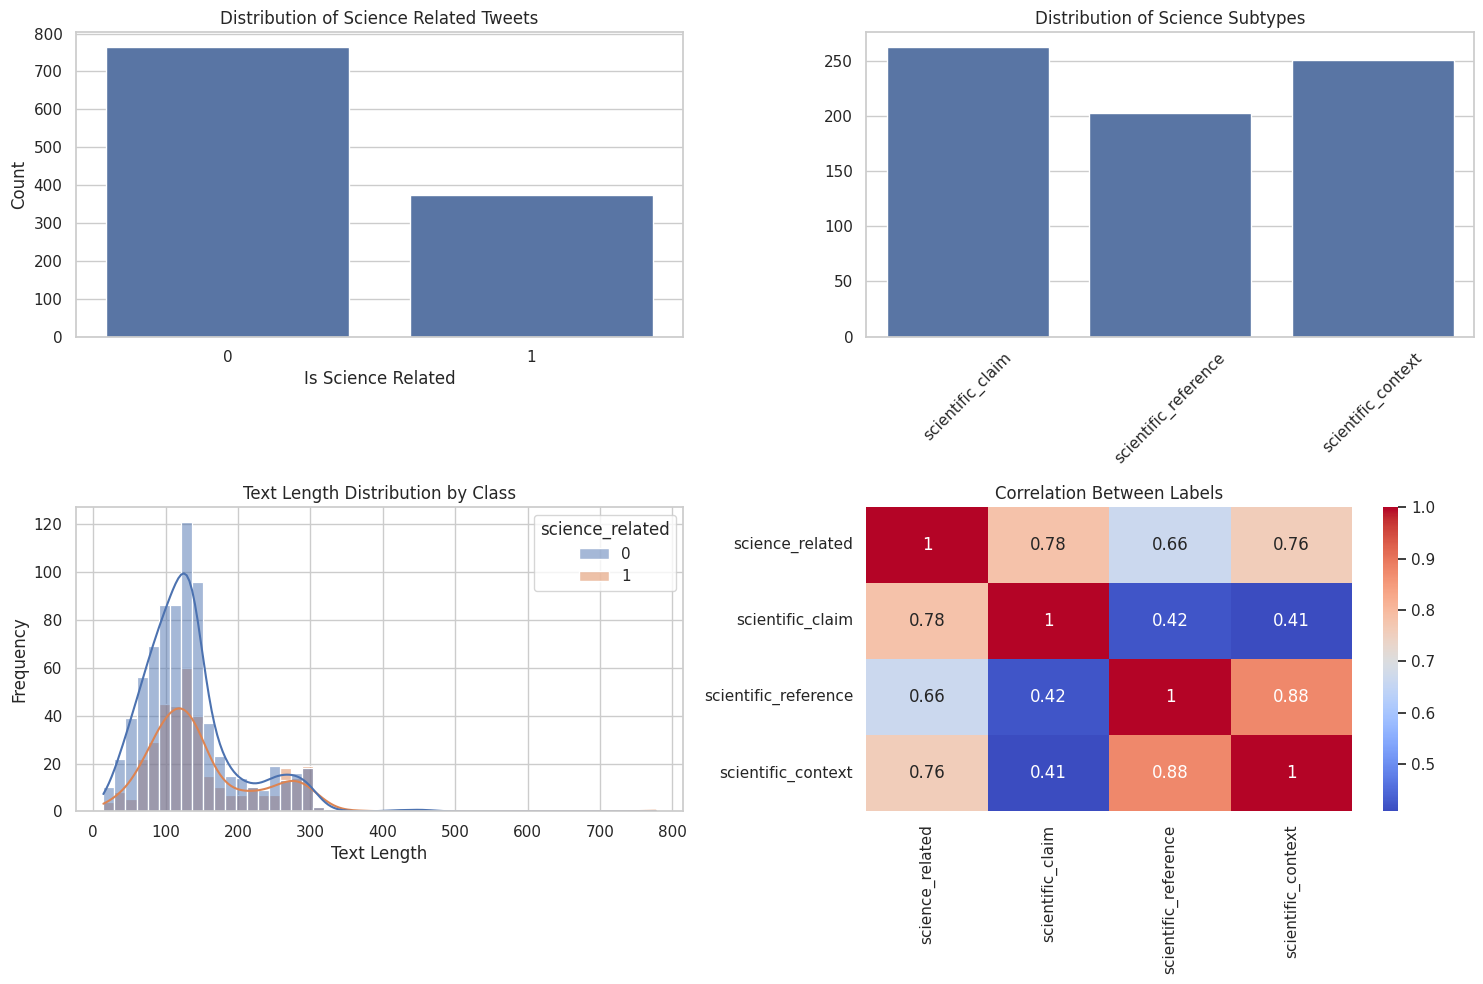

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Plot distribution of science_related tweets
plt.subplot(2, 2, 1)
sns.countplot(x='science_related', data=df)
plt.title('Distribution of Science Related Tweets')
plt.xlabel('Is Science Related')
plt.ylabel('Count')

# Plot distribution of science subtypes for science-related tweets
sci_df = df[df['science_related'] == 1]
plt.subplot(2, 2, 2)
subtypes = ['scientific_claim', 'scientific_reference', 'scientific_context']
sns.barplot(x=subtypes, y=[sci_df[col].sum() for col in subtypes])
plt.title('Distribution of Science Subtypes')
plt.xticks(rotation=45)
plt.tight_layout()

# Plot text length distribution
plt.subplot(2, 2, 3)
df['text_length'] = df['text'].apply(len)
sns.histplot(data=df, x='text_length', hue='science_related', bins=50, kde=True)
plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Plot correlation between features
plt.subplot(2, 2, 4)
corr_cols = ['science_related', 'scientific_claim', 'scientific_reference', 'scientific_context']
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Labels')

plt.tight_layout()
plt.show()

## 2. Data Preprocessing Enhancements
We'll enhance the text preprocessing to improve the model performance.

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import emoji

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Demojize text
    text = emoji.demojize(text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]


    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin
    return ' '.join(tokens)

# Apply preprocessing to the dataset
df['processed_text'] = df['text'].apply(preprocess_text)

# Compare before and after
comparison_df = pd.DataFrame({
    'Original': df['text'].head(5),
    'Preprocessed': df['processed_text'].head(5)
})
comparison_df

[nltk_data] Downloading package stopwords to /home/hurel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hurel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/hurel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/hurel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Original,Preprocessed
0,Knees are a bit sore. i guess that's a sign th...,knee bit sore guess thats sign recent treadmil...
1,McDonald's breakfast stop then the gym 🏀💪,mcdonalds breakfast stop gym basketballflexedb...
2,Can any Gynecologist with Cancer Experience ex...,gynecologist cancer experience explain danger ...
3,Couch-lock highs lead to sleeping in the couch...,couchlock high lead sleeping couch got ta stop...
4,Does daily routine help prevent problems with ...,daily routine help prevent problem bipolar dis...


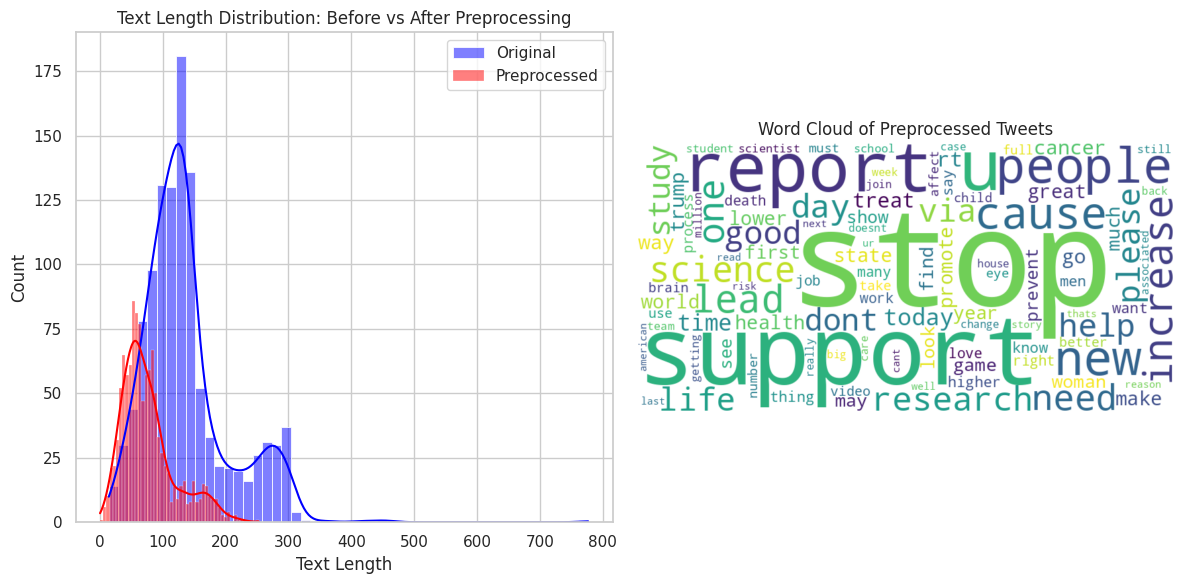

In [6]:
# Visualize the impact of preprocessing
plt.figure(figsize=(12, 6))

# Text length before and after preprocessing
df['original_length'] = df['text'].apply(len)
df['processed_length'] = df['processed_text'].apply(len)

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='original_length', color='blue', bins=50, kde=True, label='Original')
sns.histplot(data=df, x='processed_length', color='red', bins=50, kde=True, label='Preprocessed')
plt.title('Text Length Distribution: Before vs After Preprocessing')
plt.xlabel('Text Length')
plt.legend()

# Word cloud for processed text
from wordcloud import WordCloud

plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(' '.join(df['processed_text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Tweets')

plt.tight_layout()
plt.show()

## 3. Feature Engineering and Selection
Let's explore different feature extraction methods and compare them.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_all = vectorizer.fit_transform(df['text'])

Count Vectorizer Features: (1140, 5000)
TF-IDF Vectorizer Features: (1140, 464)
TF-IDF on Preprocessed Text Features: (1140, 5000)


/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous value


Features after Chi-squared selection: (1140, 100)
Features after Mutual Information selection: (1140, 100)


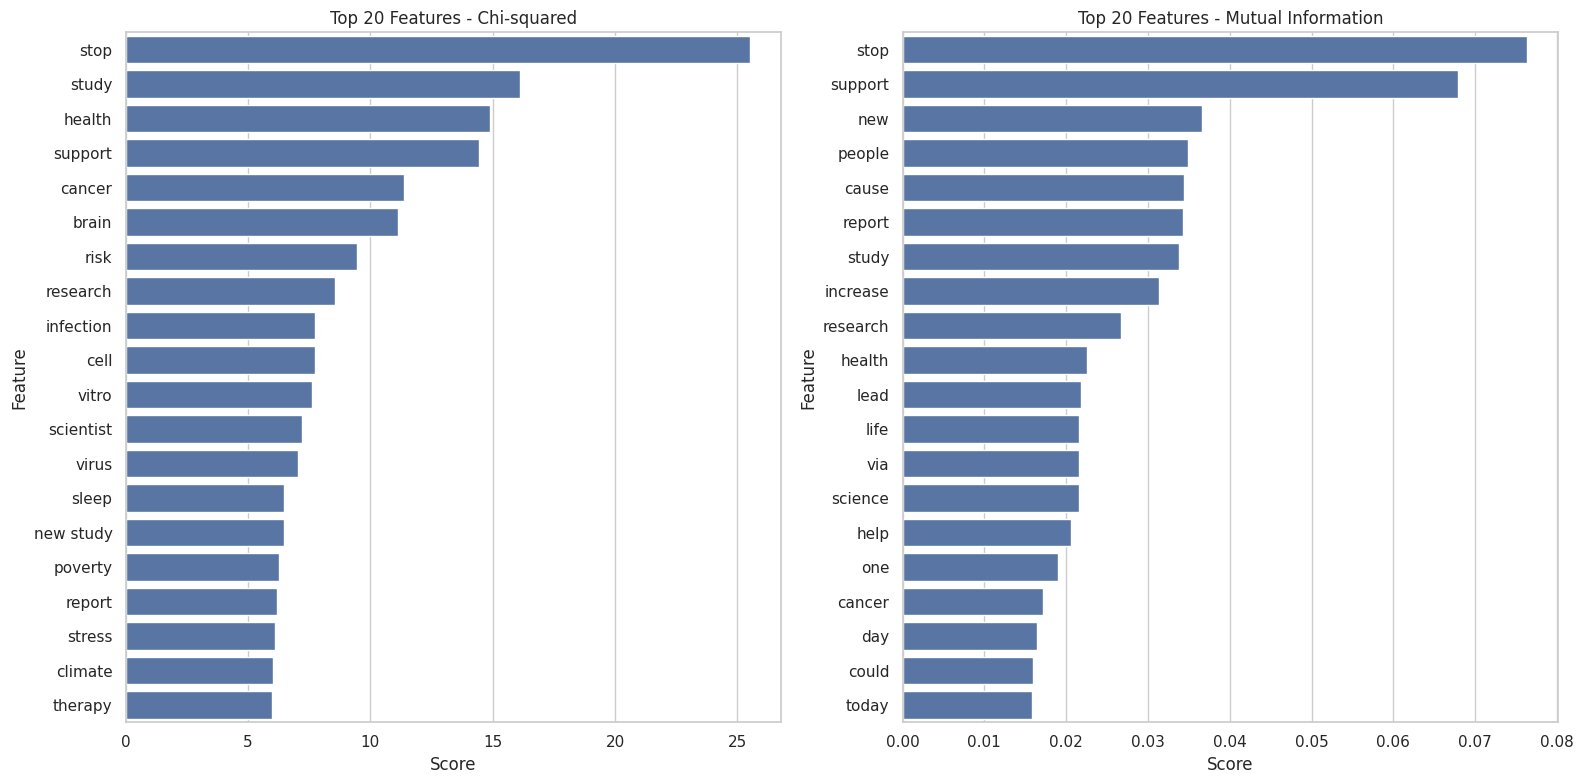

In [8]:
# Compare different feature extraction methods
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Create label for Task 1
y_task1 = df['science_related']

# 1. Count Vectorizer
count_vec = CountVectorizer(max_features=5000)
X_count = count_vec.fit_transform(df['processed_text'])

# 2. TF-IDF with more parameters
tfidf_vec = TfidfVectorizer(max_features=5000, 
                           min_df=5, 
                           max_df=0.8, 
                           ngram_range=(1, 2))
X_tfidf = tfidf_vec.fit_transform(df['processed_text'])

# 3. TF-IDF with preprocessing already done
tfidf_processed = TfidfVectorizer(max_features=5000)
X_tfidf_processed = tfidf_processed.fit_transform(df['processed_text'])

# Compare feature extraction methods
print(f"Count Vectorizer Features: {X_count.shape}")
print(f"TF-IDF Vectorizer Features: {X_tfidf.shape}")
print(f"TF-IDF on Preprocessed Text Features: {X_tfidf_processed.shape}")

# Feature selection using Chi-squared
selector_chi2 = SelectKBest(chi2, k=100)
X_chi2 = selector_chi2.fit_transform(X_tfidf, y_task1)

# Feature selection using Mutual Information
selector_mi = SelectKBest(mutual_info_classif, k=100)
X_mi = selector_mi.fit_transform(X_tfidf, y_task1)

print(f"\nFeatures after Chi-squared selection: {X_chi2.shape}")
print(f"Features after Mutual Information selection: {X_mi.shape}")

# Get and visualize the most important features
chi2_selected_indices = selector_chi2.get_support(indices=True)
mi_selected_indices = selector_mi.get_support(indices=True)

chi2_feature_names = np.array(tfidf_vec.get_feature_names_out())[chi2_selected_indices]
mi_feature_names = np.array(tfidf_vec.get_feature_names_out())[mi_selected_indices]

# Plot top 20 features by importance
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
chi2_scores = selector_chi2.scores_[chi2_selected_indices]
chi2_features_df = pd.DataFrame({'Feature': chi2_feature_names, 'Score': chi2_scores})
chi2_features_df = chi2_features_df.sort_values('Score', ascending=False).head(20)
sns.barplot(x='Score', y='Feature', data=chi2_features_df)
plt.title('Top 20 Features - Chi-squared')

plt.subplot(1, 2, 2)
mi_scores = selector_mi.scores_[mi_selected_indices]
mi_features_df = pd.DataFrame({'Feature': mi_feature_names, 'Score': mi_scores})
mi_features_df = mi_features_df.sort_values('Score', ascending=False).head(20)
sns.barplot(x='Score', y='Feature', data=mi_features_df)
plt.title('Top 20 Features - Mutual Information')

plt.tight_layout()
plt.show()

# We'll use the TF-IDF on preprocessed text for subsequent modeling
X_selected = X_tfidf

In [9]:
# Create labels for all tasks
df['task1_label'] = df['science_related']

df_sci = df[df['science_related'] == 1].copy()
df_sci['task2_label'] = ((df_sci['scientific_claim'] == 1.0) | (df_sci['scientific_reference'] == 1.0)).astype(int)
df_sci['task3_label'] = df_sci[['scientific_claim', 'scientific_reference', 'scientific_context']].idxmax(axis=1)
df_sci['task3_label'] = df_sci['task3_label'].map({
    'scientific_claim': 0,
    'scientific_reference': 1,
    'scientific_context': 2
})

## 4. Naive Bayes Models Comparison
Let's compare different Naive Bayes variants for our tasks.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }

# Get a dense version of our features for Gaussian NB
X_dense = X_selected.toarray()

# Split data for Task 1
X_train_task1, X_test_task1, y_train_task1, y_test_task1 = train_test_split(
    X_dense, df['task1_label'], test_size=0.2, random_state=42
)

# Compare different NB variants for Task 1
nb_models = {
    'Gaussian NB': GaussianNB(),
    'Multinomial NB': MultinomialNB(),
    'Complement NB': ComplementNB(),
    'Bernoulli NB': BernoulliNB()
}

task1_results = {}
print("Task 1: Science Related Classification\n" + "="*40)
for name, model in nb_models.items():
    task1_results[name] = evaluate_model(
        model, X_train_task1, X_test_task1, y_train_task1, y_test_task1, name
    )
    print("\n")

Task 1: Science Related Classification
Model: Gaussian NB
Accuracy: 0.5921
              precision    recall  f1-score   support

           0       0.77      0.51      0.62       146
           1       0.46      0.73      0.56        82

    accuracy                           0.59       228
   macro avg       0.62      0.62      0.59       228
weighted avg       0.66      0.59      0.60       228



Model: Multinomial NB
Accuracy: 0.7412
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       146
           1       0.78      0.39      0.52        82

    accuracy                           0.74       228
   macro avg       0.76      0.66      0.67       228
weighted avg       0.75      0.74      0.71       228



Model: Complement NB
Accuracy: 0.7412
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       146
           1       0.62      0.71      0.66        82

    accuracy              

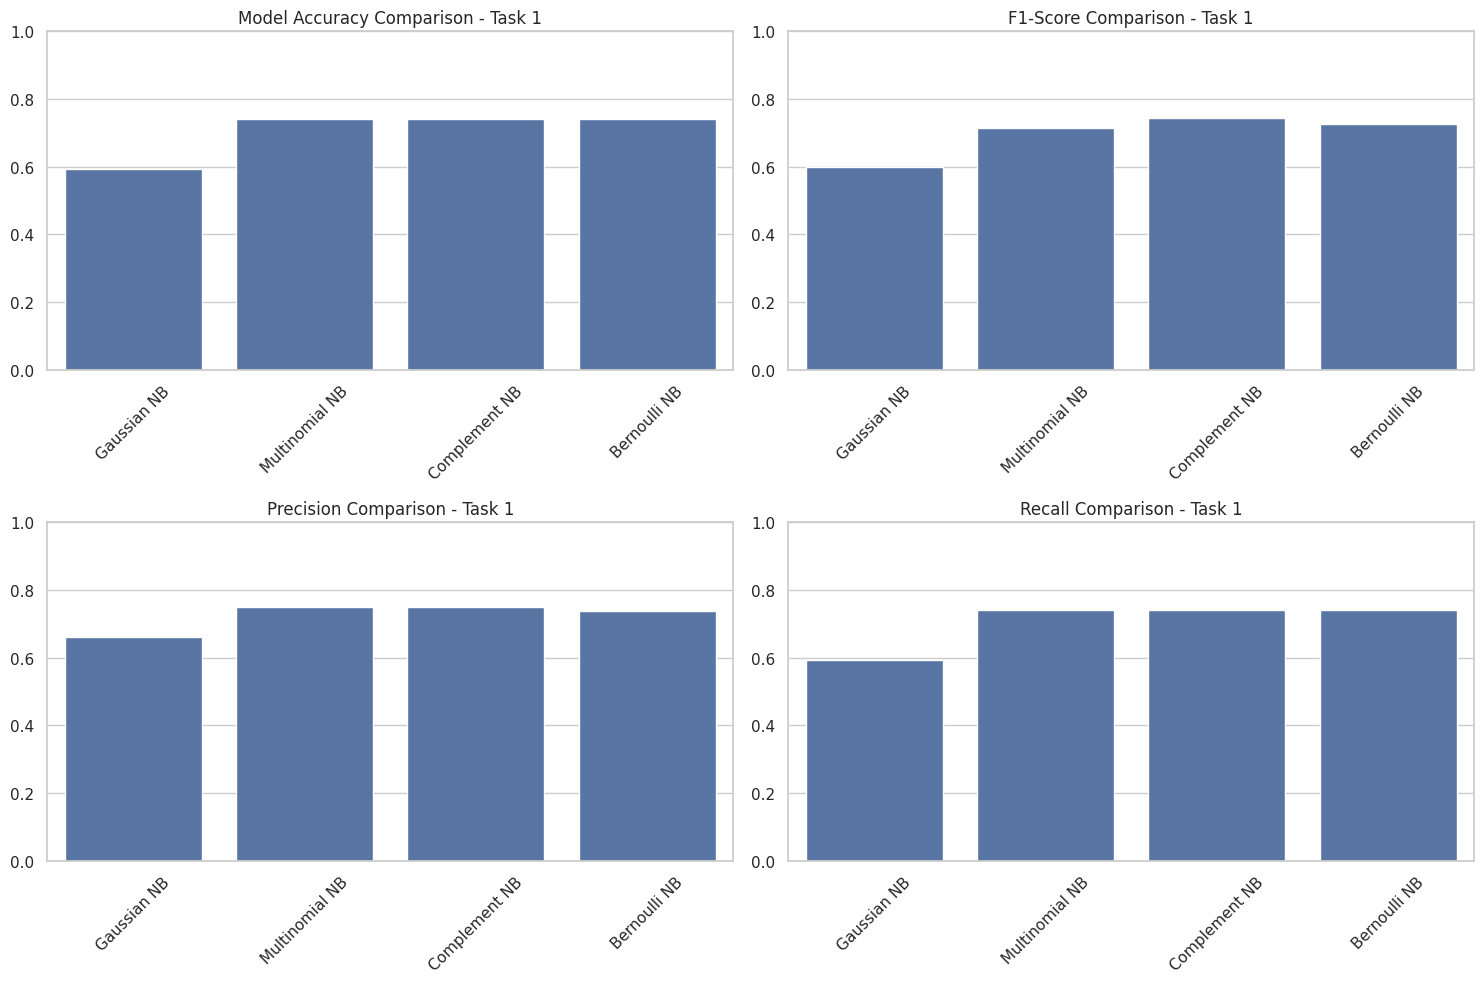

In [11]:
# Visualize Task 1 results
plt.figure(figsize=(15, 10))

# Accuracy comparison
plt.subplot(2, 2, 1)
accuracies = [result['accuracy'] for result in task1_results.values()]
model_names = list(task1_results.keys())
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Accuracy Comparison - Task 1')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# F1-Score comparison
plt.subplot(2, 2, 2)
f1_scores = [result['report']['weighted avg']['f1-score'] for result in task1_results.values()]
sns.barplot(x=model_names, y=f1_scores)
plt.title('F1-Score Comparison - Task 1')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Precision comparison
plt.subplot(2, 2, 3)
precision = [result['report']['weighted avg']['precision'] for result in task1_results.values()]
sns.barplot(x=model_names, y=precision)
plt.title('Precision Comparison - Task 1')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Recall comparison
plt.subplot(2, 2, 4)
recall = [result['report']['weighted avg']['recall'] for result in task1_results.values()]
sns.barplot(x=model_names, y=recall)
plt.title('Recall Comparison - Task 1')
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [12]:
# Task 2 and Task 3 with the best NB variant from Task 1
best_nb_model = MultinomialNB()

# Get indices of science-related tweets
science_indices = df[df['science_related'] == 1].index

# Use those indices to select rows from X_selected
X_sci = X_selected[science_indices]
X_sci_dense = X_sci.toarray()

# Task 2: Split data
X_train_task2, X_test_task2, y_train_task2, y_test_task2 = train_test_split(
    X_sci_dense, df_sci['task2_label'], test_size=0.2, random_state=42
)

# Task 3: Split data
X_train_task3, X_test_task3, y_train_task3, y_test_task3 = train_test_split(
    X_sci_dense, df_sci['task3_label'], test_size=0.2, random_state=42
)

# Evaluate on Task 2
print("Task 2: Scientific Claim/Reference Classification\n" + "="*50)
task2_result = evaluate_model(
    best_nb_model, X_train_task2, X_test_task2, y_train_task2, y_test_task2, 'Multinomial NB'
)

# Evaluate on Task 3
print("\nTask 3: Scientific Type Classification\n" + "="*40)
task3_result = evaluate_model(
    best_nb_model, X_train_task3, X_test_task3, y_train_task3, y_test_task3, 'Multinomial NB'
)

Task 2: Scientific Claim/Reference Classification
Model: Multinomial NB
Accuracy: 0.9067
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95        68

    accuracy                           0.91        75
   macro avg       0.45      0.50      0.48        75
weighted avg       0.82      0.91      0.86        75


Task 3: Scientific Type Classification
Model: Multinomial NB
Accuracy: 0.7467
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        54
           1       0.67      0.14      0.24        14
           2       0.00      0.00      0.00         7

    accuracy                           0.75        75
   macro avg       0.47      0.38      0.36        75
weighted avg       0.66      0.75      0.66        75



/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

## 5. Multiple Model Comparison
Compare different machine learning models for our classification tasks.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define models to compare
models = {
    'Multinomial NB': MultinomialNB(),
    'Linear SVM': Pipeline([('scaler', StandardScaler(with_mean=False)), ('svm', LinearSVC(max_iter=10000))]),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Evaluate all models on Task 1
task1_all_results = {}
print("Task 1: Multiple Model Comparison\n" + "="*40)
for name, model in models.items():
    task1_all_results[name] = evaluate_model(
        model, X_train_task1, X_test_task1, y_train_task1, y_test_task1, name
    )
    print("\n")

# Create a comparison dataframe
comparison_data = []
for name, result in task1_all_results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': result['accuracy'],
        'Precision': result['report']['weighted avg']['precision'],
        'Recall': result['report']['weighted avg']['recall'],
        'F1-Score': result['report']['weighted avg']['f1-score']
    })
    
comparison_df = pd.DataFrame(comparison_data)
print("Performance Metrics Comparison:")
comparison_df

Task 1: Multiple Model Comparison
Model: Multinomial NB
Accuracy: 0.7412
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       146
           1       0.78      0.39      0.52        82

    accuracy                           0.74       228
   macro avg       0.76      0.66      0.67       228
weighted avg       0.75      0.74      0.71       228



Model: Linear SVM
Accuracy: 0.6711
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       146
           1       0.54      0.60      0.57        82

    accuracy                           0.67       228
   macro avg       0.65      0.65      0.65       228
weighted avg       0.68      0.67      0.67       228



Model: Random Forest
Accuracy: 0.7632
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       146
           1       0.66      0.70      0.68        82

    accuracy                    

,Model,Accuracy,Precision,Recall,F1-Score
0,Multinomial NB,0.741228,0.749836,0.741228,0.714030
1,Linear SVM,0.671053,0.679763,0.671053,0.674378
2,Random Forest,0.763158,0.765985,0.763158,0.764333
3,Logistic Regression,0.714912,0.725633,0.714912,0.674659


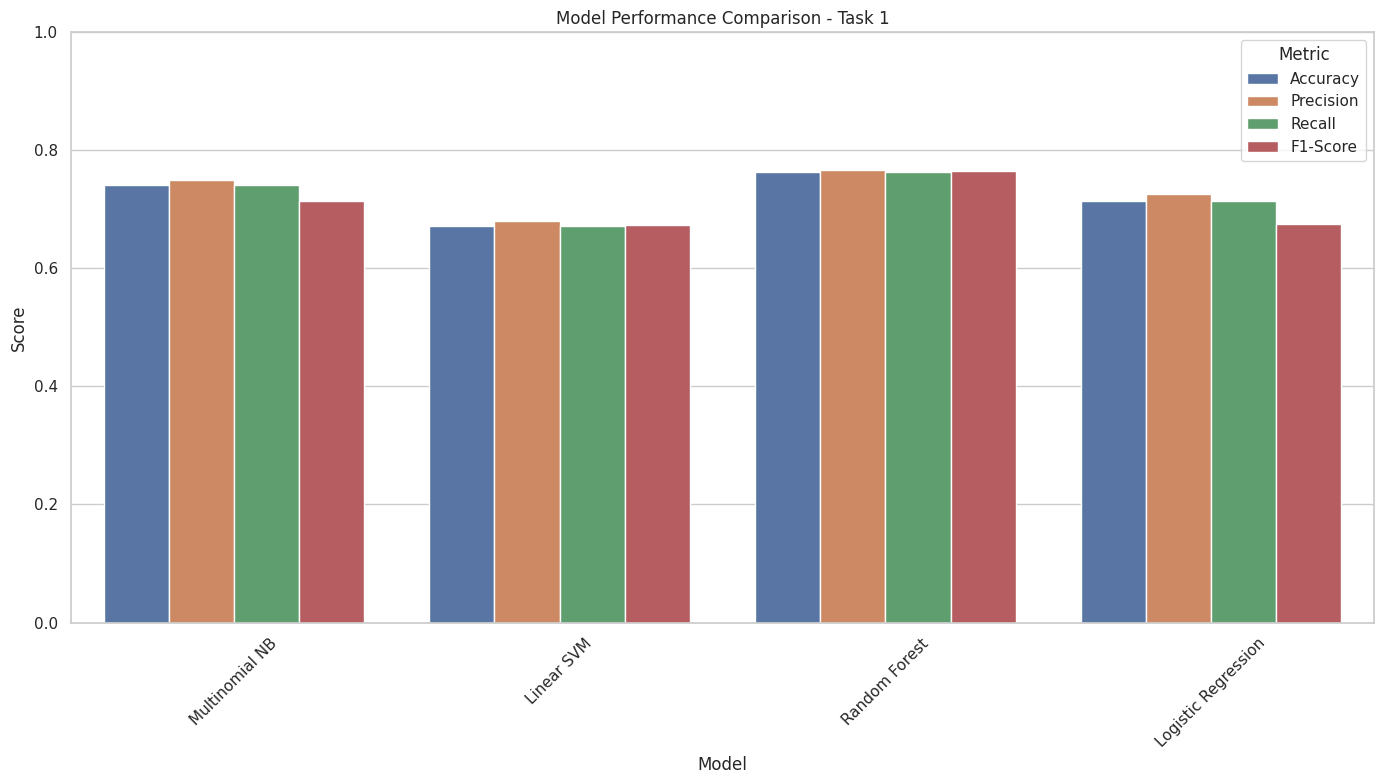

In [14]:
# Plot model comparison
plt.figure(figsize=(14, 8))

# Plot comparison metrics as grouped bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
model_names = comparison_df['Model'].tolist()

# Prepare the data for grouped bar chart
data_for_plot = comparison_df.melt(id_vars=['Model'], 
                                  value_vars=metrics,
                                  var_name='Metric', 
                                  value_name='Score')

# Plot grouped bar chart
sns.barplot(x='Model', y='Score', hue='Metric', data=data_for_plot)
plt.title('Model Performance Comparison - Task 1')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## 6. Hyperparameter Tuning
Let's tune the hyperparameters of our best models to improve performance.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best Parameters: {'alpha': 0.5, 'fit_prior': True}
Best Cross-Validation Score: 0.7818
Test Accuracy with Best Parameters: 0.7325


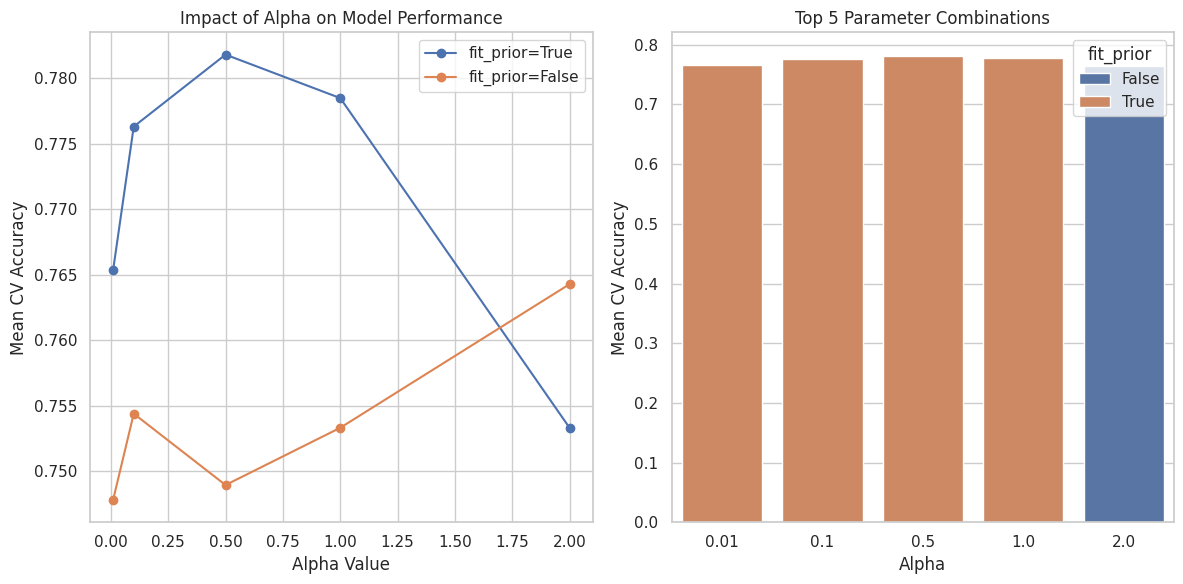

In [15]:
from sklearn.model_selection import GridSearchCV

# Choose the best model from previous comparison (assuming Multinomial NB for demonstration)
best_model = MultinomialNB()

# Define parameter grid for Multinomial NB
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X_train_task1, y_train_task1)

# Get the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# Evaluate the best model
best_model = grid_search.best_estimator_
best_model_accuracy = best_model.score(X_test_task1, y_test_task1)
print(f"Test Accuracy with Best Parameters: {best_model_accuracy:.4f}")

# Visualize parameter impact
results = pd.DataFrame(grid_search.cv_results_)

# Plot effect of alpha
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
alpha_values = param_grid['alpha']
for fit_prior in param_grid['fit_prior']:
    mean_scores = []
    for alpha in alpha_values:
        mean_scores.append(results[
            (results['param_alpha'] == alpha) & 
            (results['param_fit_prior'] == fit_prior)
        ]['mean_test_score'].values[0])
    plt.plot(alpha_values, mean_scores, marker='o', label=f'fit_prior={fit_prior}')

plt.xlabel('Alpha Value')
plt.ylabel('Mean CV Accuracy')
plt.title('Impact of Alpha on Model Performance')
plt.legend()
plt.grid(True)

# Plot best parameters
plt.subplot(1, 2, 2)
results_sorted = results.sort_values(by='rank_test_score')
sns.barplot(x='param_alpha', y='mean_test_score', hue='param_fit_prior', data=results_sorted.head(5))
plt.xlabel('Alpha')
plt.ylabel('Mean CV Accuracy')
plt.title('Top 5 Parameter Combinations')
plt.legend(title='fit_prior')

plt.tight_layout()
plt.show()

## 7. Performance Visualization
Create detailed visualizations of model performance.

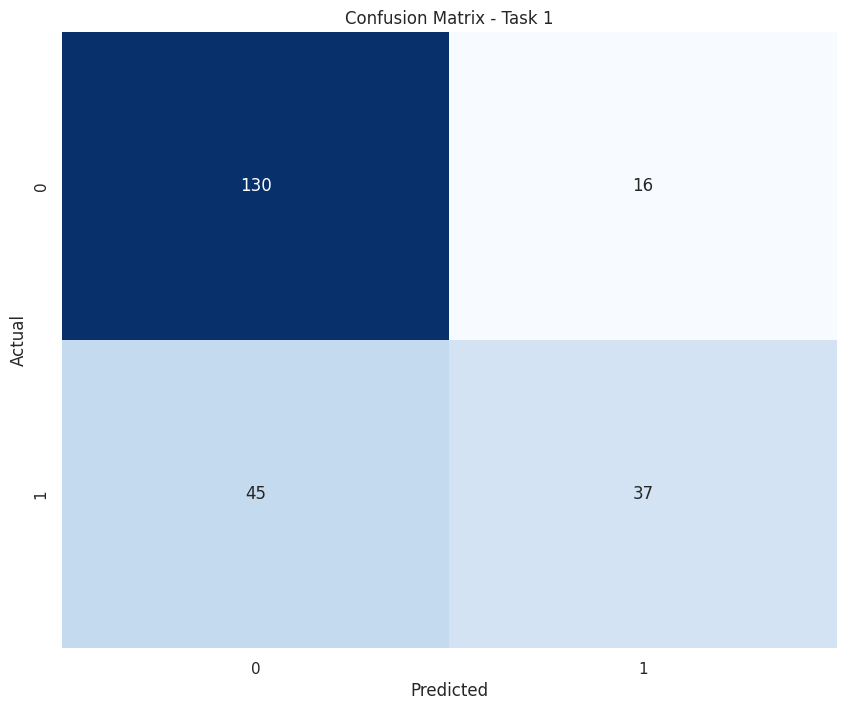

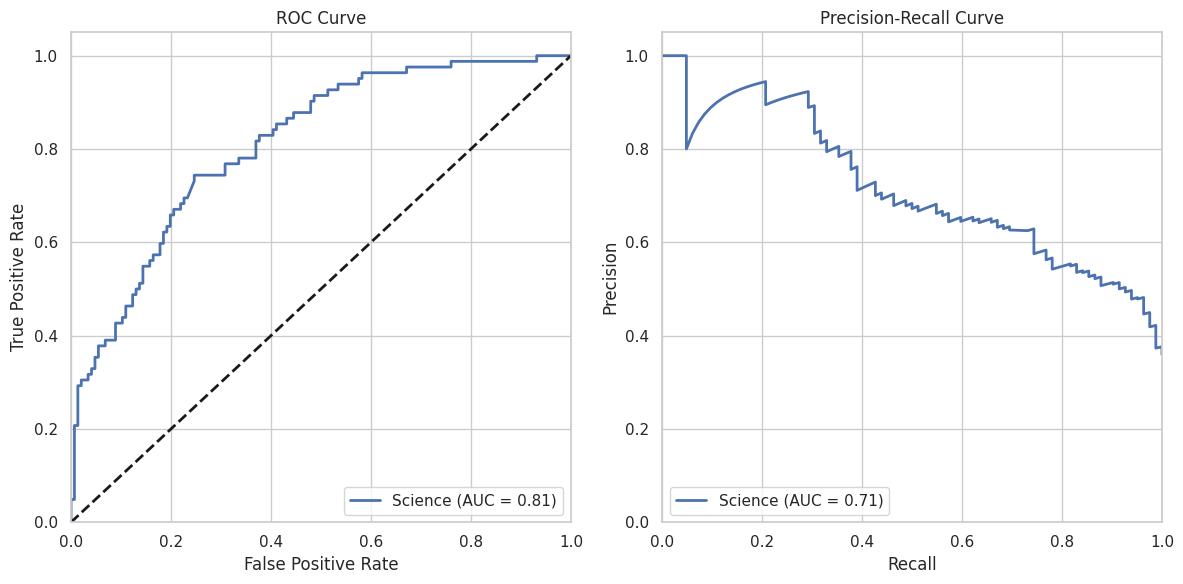

In [16]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay

# Get the best model from hyperparameter tuning
best_model = grid_search.best_estimator_

# Make predictions with probability estimates
y_proba = best_model.predict_proba(X_test_task1)
y_pred = best_model.predict(X_test_task1)

# Create confusion matrix
cm = confusion_matrix(y_test_task1, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Task 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve and PR curve
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
for i, class_name in enumerate(['Non-Science', 'Science']):
    if len(np.unique(y_test_task1)) <= 2:  # Binary classification
        if i == 1:  # Only plot for the positive class in binary classification
            fpr, tpr, _ = roc_curve(y_test_task1, y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
    else:  # Multi-class classification
        y_test_bin = (y_test_task1 == i).astype(int)
        if i < y_proba.shape[1]:  # Make sure we have probabilities for this class
            fpr, tpr, _ = roc_curve(y_test_bin, y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
for i, class_name in enumerate(['Non-Science', 'Science']):
    if len(np.unique(y_test_task1)) <= 2:  # Binary classification
        if i == 1:  # Only plot for the positive class in binary classification
            precision, recall, _ = precision_recall_curve(y_test_task1, y_proba[:, i])
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, lw=2, label=f'{class_name} (AUC = {pr_auc:.2f})')
    else:  # Multi-class classification
        y_test_bin = (y_test_task1 == i).astype(int)
        if i < y_proba.shape[1]:  # Make sure we have probabilities for this class
            precision, recall, _ = precision_recall_curve(y_test_bin, y_proba[:, i])
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, lw=2, label=f'{class_name} (AUC = {pr_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis
Analyze and visualize the most important features for each task.

In [17]:
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np

selector = SelectKBest(chi2, k=20)
selector.fit(X_all, df['task1_label'])
selected_words = np.array(vectorizer.get_feature_names_out())[selector.get_support()]
print("Top words discriminant (Task 1):", selected_words)

Top words discriminant (Task 1): ['brain' 'cancer' 'climate' 'diabetes' 'drug' 'eurekamag' 'health'
 'infection' 'lives' 'poverty' 'reduces' 'reports' 'research' 'risk'
 'scientists' 'sleep' 'stop' 'stress' 'study' 'support']


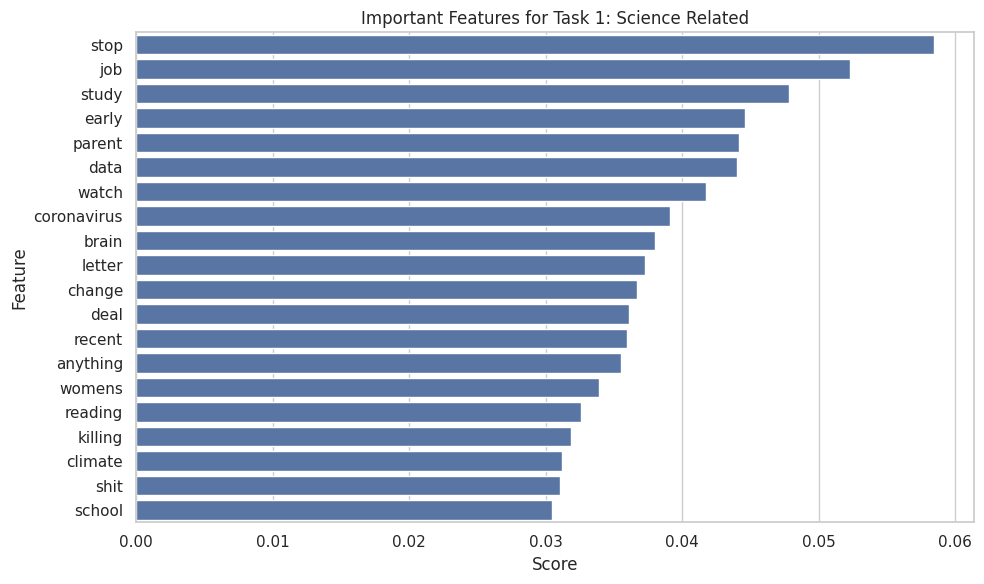

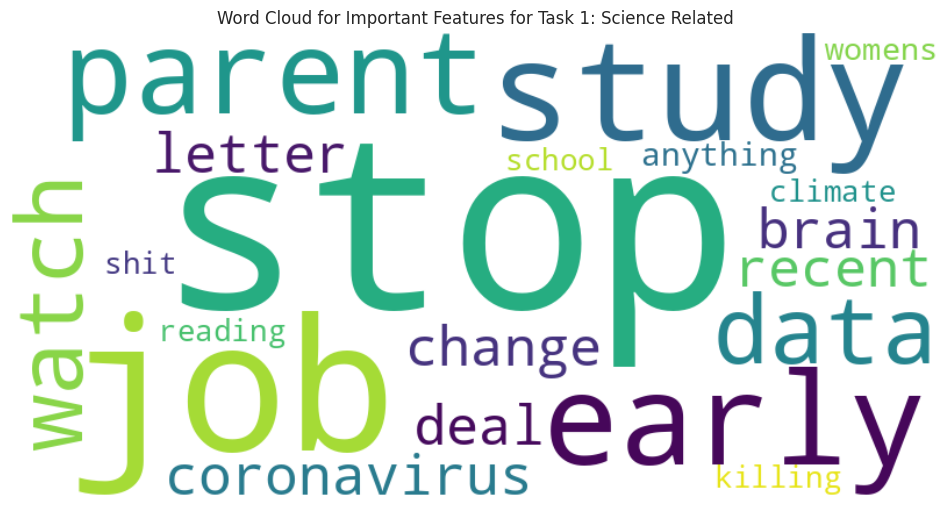

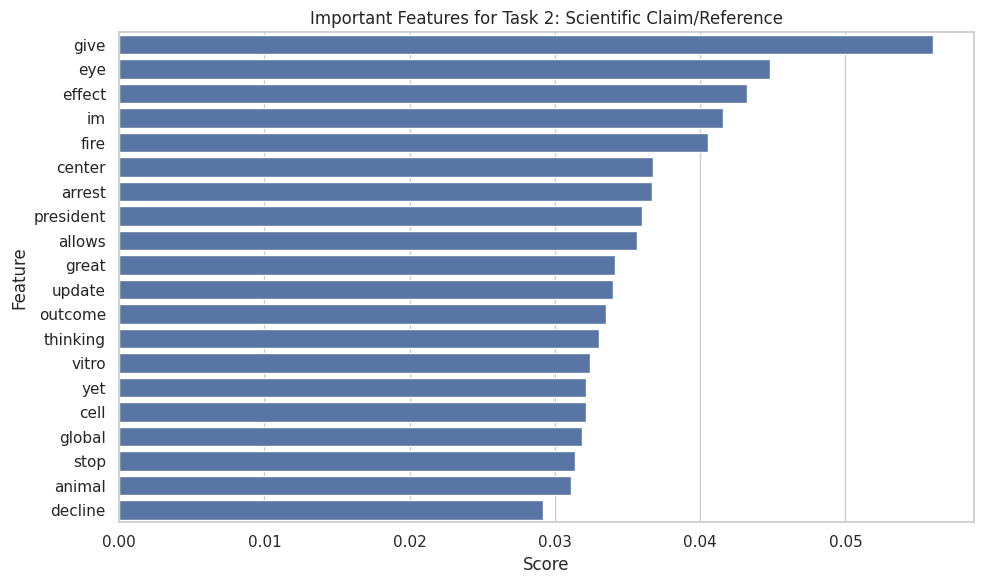

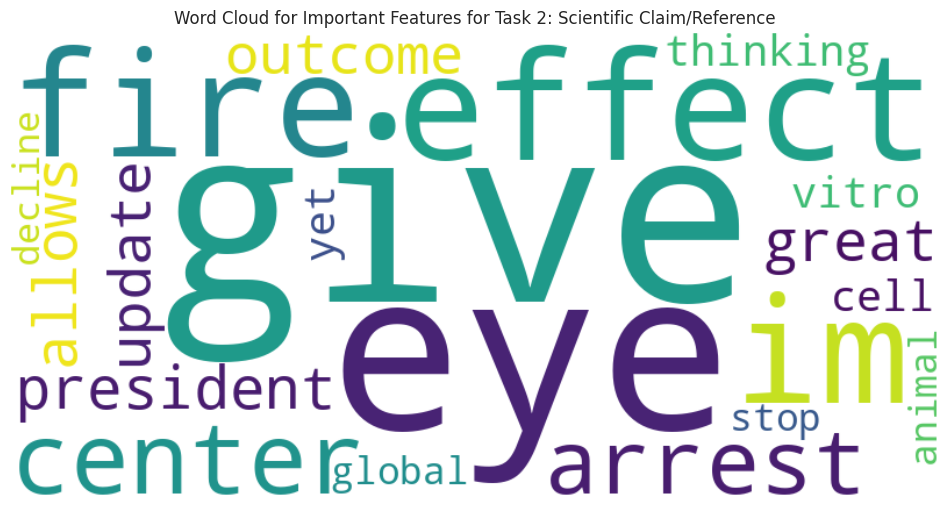

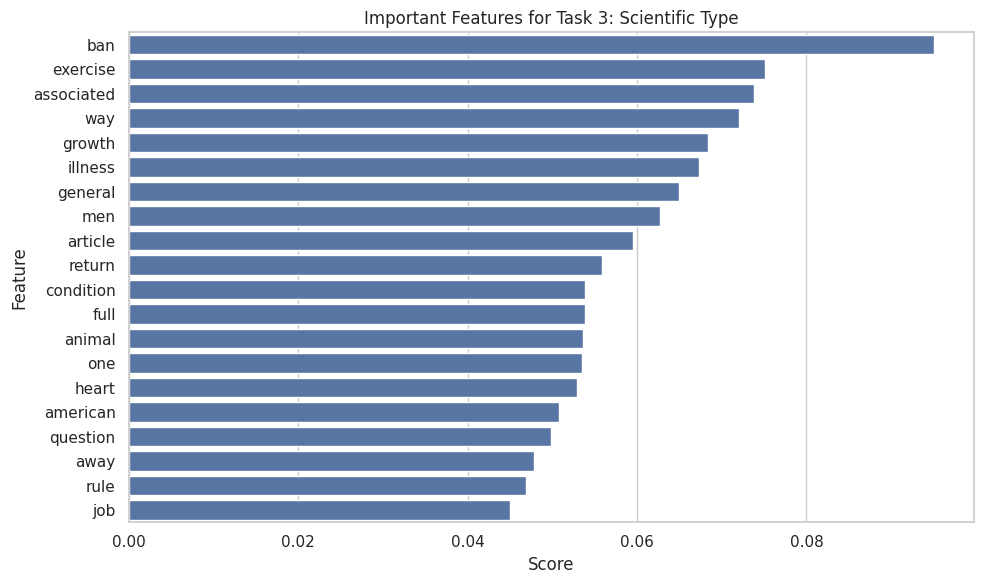

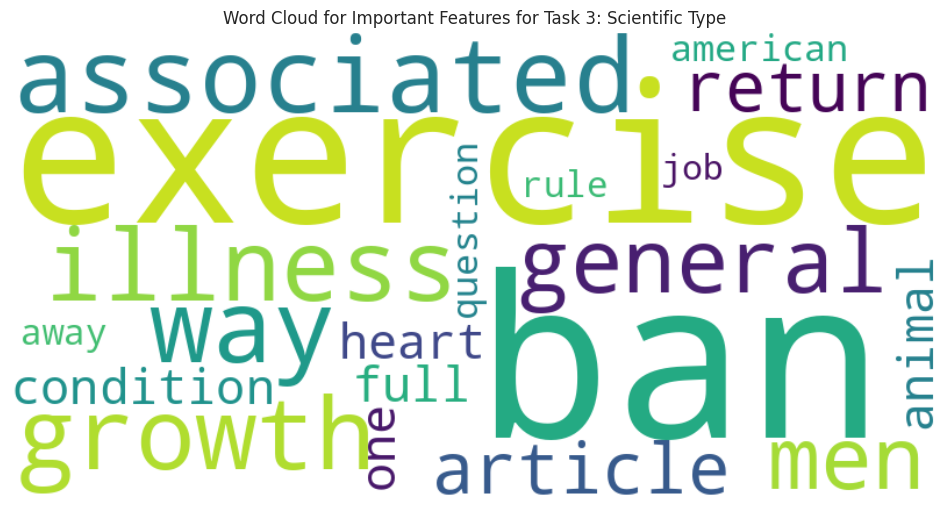

In [18]:
# Get feature importance for all three tasks
from sklearn.feature_selection import mutual_info_classif
from wordcloud import WordCloud

# Function to extract and visualize important features
def get_important_features(X, y, vectorizer, n_features=20, title="Feature Importance"):
    # Get feature importance using mutual information
    selector = SelectKBest(mutual_info_classif, k=n_features)
    selector.fit(X, y)
    
    # Get selected feature names
    feature_names = vectorizer.get_feature_names_out()
    selected_features = np.array(feature_names)[selector.get_support()]
    
    # Get scores for selected features
    scores = selector.scores_[selector.get_support()]
    
    # Create dataframe of features and scores
    features_df = pd.DataFrame({
        'Feature': selected_features,
        'Score': scores
    }).sort_values('Score', ascending=False)
    
    # Plot bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Score', y='Feature', data=features_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    # Generate word cloud
    # Create a dictionary of words and their scores
    word_scores = {selected_features[i]: scores[i] for i in range(len(selected_features))}
    
    # Generate word cloud
    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         max_words=100).generate_from_frequencies(word_scores)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {title}")
    plt.show()
    
    return features_df

# Task 1: Science Related
task1_features = get_important_features(
    X_train_task1, y_train_task1, 
    tfidf_vec,
    title="Important Features for Task 1: Science Related"
)

# Task 2: Scientific Claim/Reference
task2_features = get_important_features(
    X_train_task2, y_train_task2, 
    tfidf_vec, 
    title="Important Features for Task 2: Scientific Claim/Reference"
)

# Task 3: Scientific Type
task3_features = get_important_features(
    X_train_task3, y_train_task3, 
    tfidf_vec, 
    title="Important Features for Task 3: Scientific Type"
)

## 9. Cross-Validation Implementation
Implement K-fold cross-validation for more robust model evaluation.

Cross-validation for Task 1:
Multinomial NB - Mean Accuracy: 0.7737, Std: 0.0236
Linear SVM - Mean Accuracy: 0.6842, Std: 0.0510
Random Forest - Mean Accuracy: 0.7842, Std: 0.0191
Logistic Regression - Mean Accuracy: 0.7711, Std: 0.0241


/tmp/ipykernel_44084/2168306570.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_data, labels=model_names)


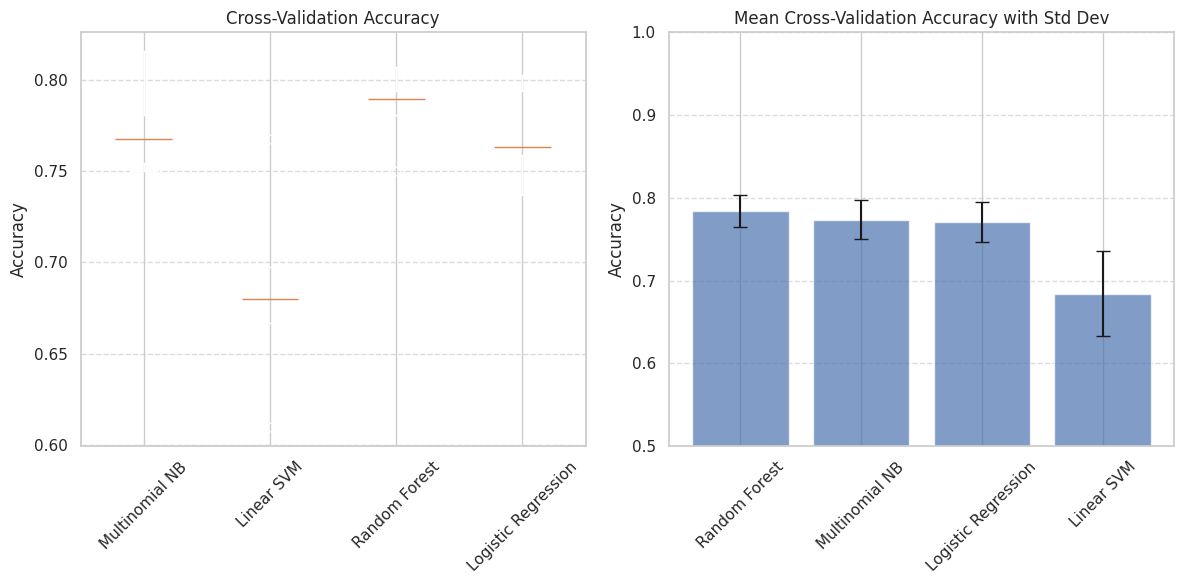

In [19]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compare models with cross-validation
def compare_models_cv(models, X, y, cv=cv):
    results = {}
    
    for name, model in models.items():
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        results[name] = {
            'mean_accuracy': cv_scores.mean(),
            'std_accuracy': cv_scores.std(),
            'all_scores': cv_scores
        }
        print(f"{name} - Mean Accuracy: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")
    
    return results

# Compare all models on Task 1
print("Cross-validation for Task 1:\n" + "="*30)
task1_cv_results = compare_models_cv(models, X_dense, df['task1_label'])

# Create dataframe for visualization
cv_results_df = pd.DataFrame({
    'Model': list(task1_cv_results.keys()),
    'Mean Accuracy': [result['mean_accuracy'] for result in task1_cv_results.values()],
    'Std Accuracy': [result['std_accuracy'] for result in task1_cv_results.values()]
}).sort_values('Mean Accuracy', ascending=False)

# Plot cross-validation results
plt.figure(figsize=(12, 6))

# Boxplot of CV scores
plt.subplot(1, 2, 1)
cv_data = []
model_names = []
for name, result in task1_cv_results.items():
    cv_data.append(result['all_scores'])
    model_names.append(name)

plt.boxplot(cv_data, labels=model_names)
plt.title('Cross-Validation Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Bar plot with error bars
plt.subplot(1, 2, 2)
plt.bar(cv_results_df['Model'], cv_results_df['Mean Accuracy'], 
        yerr=cv_results_df['Std Accuracy'], 
        capsize=5, 
        alpha=0.7)
plt.title('Mean Cross-Validation Accuracy with Std Dev')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)  # Adjust as needed
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 10. Model Evaluation with Extended Metrics
Implement additional evaluation metrics for all three classification tasks.


Extended evaluation for Task 1:
Model: Multinomial NB - Task: Task 1: Science Related
Accuracy: 0.7412
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       146
           1       0.78      0.39      0.52        82

    accuracy                           0.74       228
   macro avg       0.76      0.66      0.67       228
weighted avg       0.75      0.74      0.71       228

Log Loss: 0.5055
ROC AUC: 0.8237


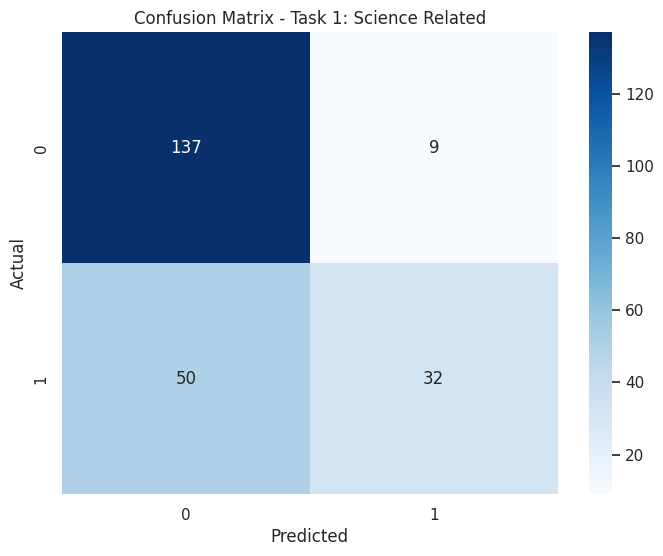

<Figure size 1200x600 with 0 Axes>

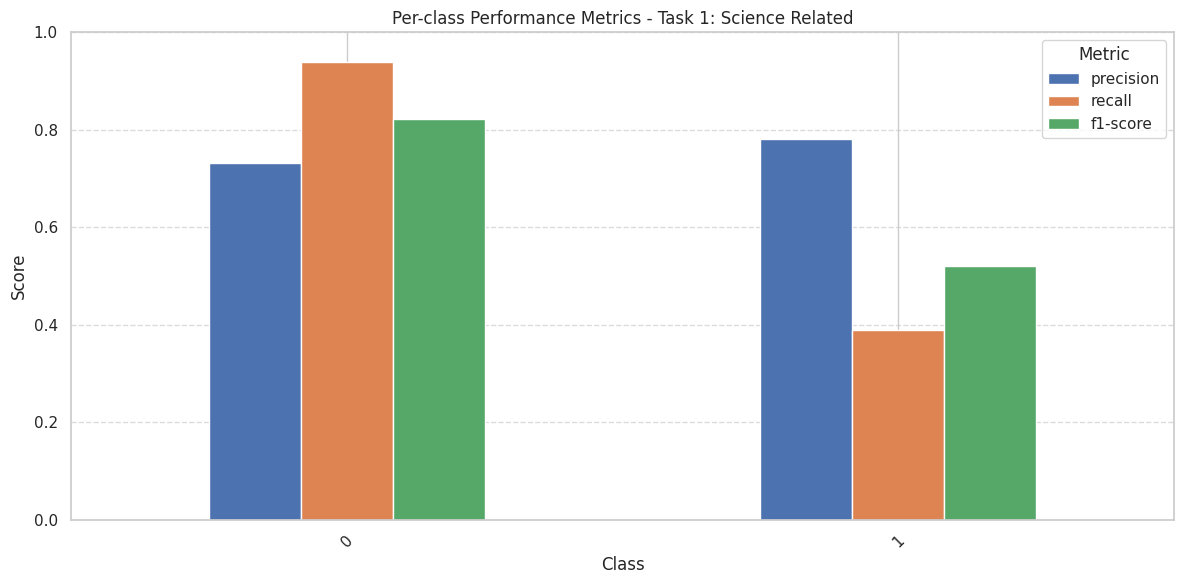


Extended evaluation for Task 2:
Model: Multinomial NB - Task: Task 2: Scientific Claim/Reference
Accuracy: 0.9067
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95        68

    accuracy                           0.91        75
   macro avg       0.45      0.50      0.48        75
weighted avg       0.82      0.91      0.86        75

Log Loss: 0.2848
ROC AUC: 0.7668


/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

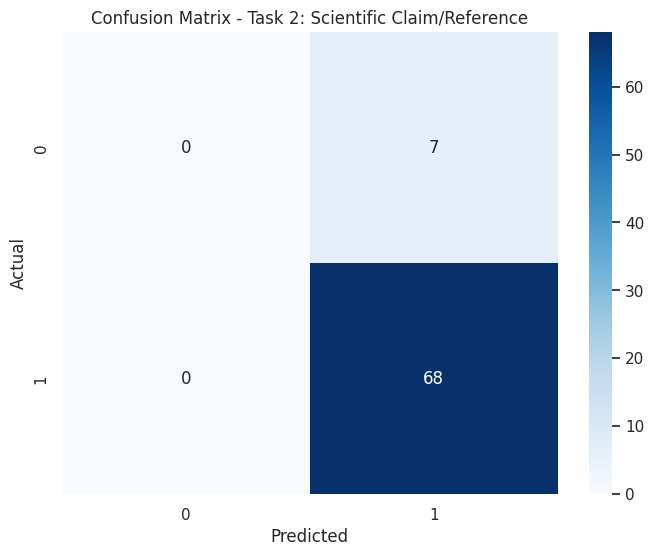

<Figure size 1200x600 with 0 Axes>

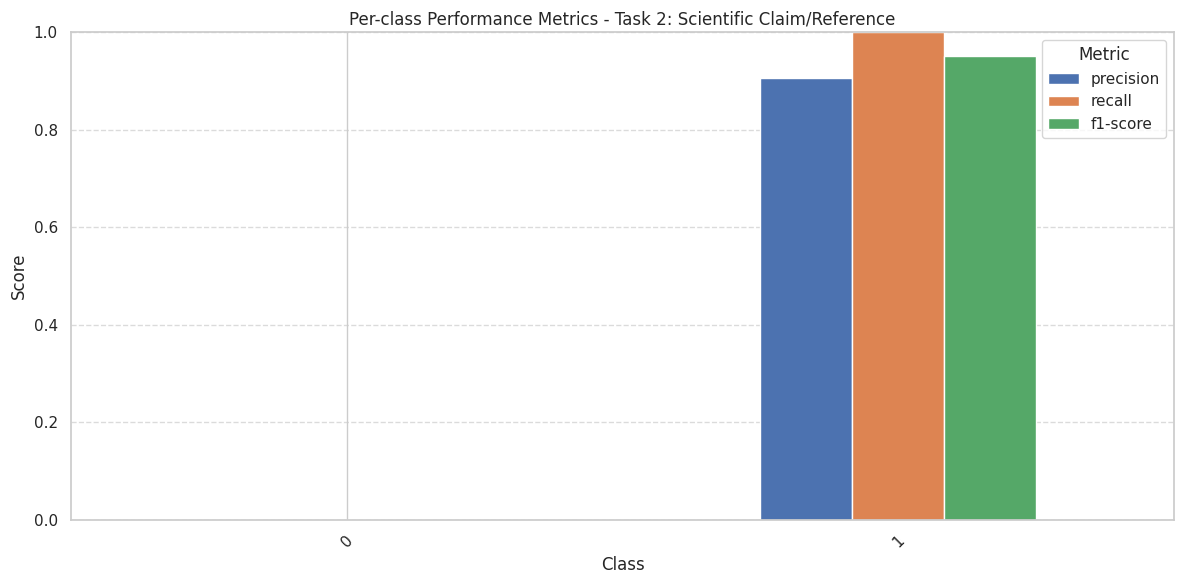


Extended evaluation for Task 3:
Model: Multinomial NB - Task: Task 3: Scientific Type
Accuracy: 0.7467
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        54
           1       0.67      0.14      0.24        14
           2       0.00      0.00      0.00         7

    accuracy                           0.75        75
   macro avg       0.47      0.38      0.36        75
weighted avg       0.66      0.75      0.66        75

Log Loss: 0.6744
ROC AUC (OvR): 0.7556


/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hurel/Documents/repo/ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

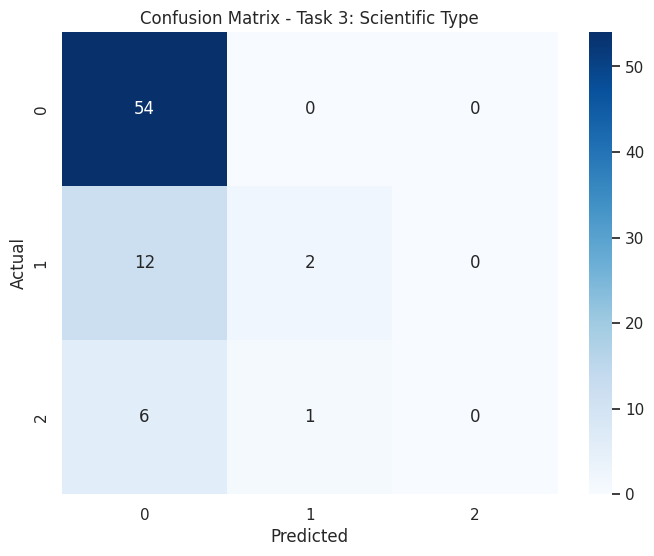

<Figure size 1200x600 with 0 Axes>

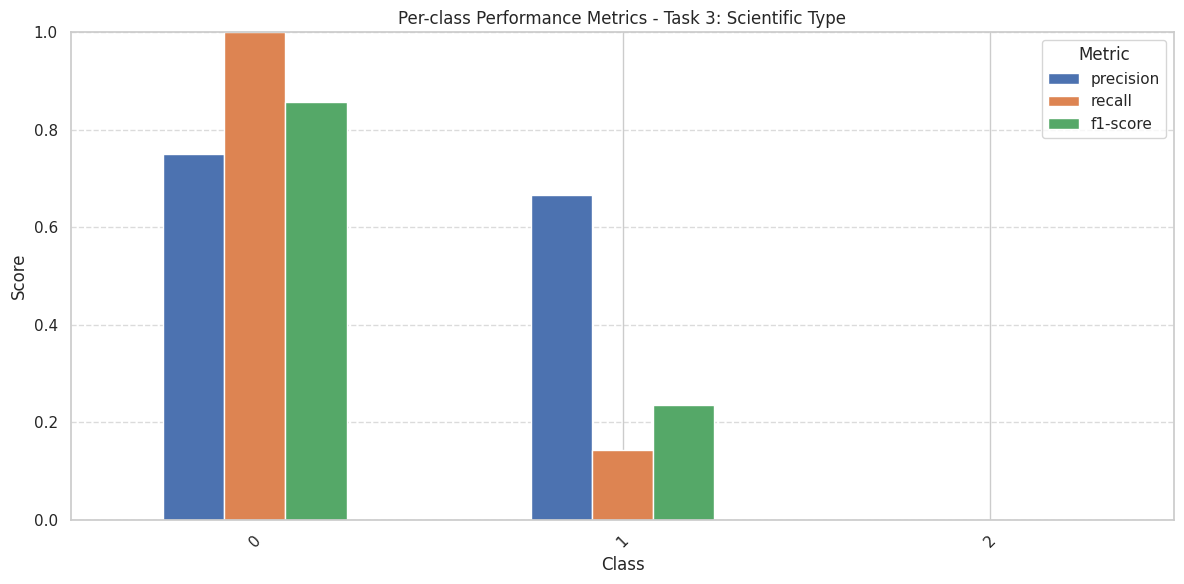

In [20]:
from sklearn.metrics import log_loss, roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import label_binarize

# Define multiple scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro',
    'log_loss': 'neg_log_loss'
}

# Function to evaluate and visualize model performance with multiple metrics
def evaluate_model_with_extended_metrics(model, X_train, X_test, y_train, y_test, model_name, task_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    try:
        y_proba = model.predict_proba(X_test)
        has_proba = True
    except:
        has_proba = False
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"Model: {model_name} - Task: {task_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Create result dictionary
    result = {
        'model_name': model_name,
        'task_name': task_name,
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }
    
    # Add log loss and ROC AUC if probabilities are available
    if has_proba:
        result['log_loss'] = log_loss(y_test, y_proba)
        print(f"Log Loss: {result['log_loss']:.4f}")
        
        # ROC AUC - handle multi-class if needed
        classes = np.unique(y_test)
        if len(classes) > 2:
            # One-vs-Rest ROC AUC for multi-class
            y_test_bin = label_binarize(y_test, classes=classes)
            if y_proba.shape[1] == len(classes):
                result['roc_auc'] = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
                print(f"ROC AUC (OvR): {result['roc_auc']:.4f}")
        else:
            # Binary ROC AUC
            result['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
            print(f"ROC AUC: {result['roc_auc']:.4f}")
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {task_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Visualize per-class metrics
    metrics = ['precision', 'recall', 'f1-score']
    class_metrics = {}
    
    for class_label in report.keys():
        if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
            class_metrics[class_label] = {metric: report[class_label][metric] for metric in metrics}
    
    class_metrics_df = pd.DataFrame(class_metrics).T
    
    plt.figure(figsize=(12, 6))
    class_metrics_df.plot(kind='bar', figsize=(12, 6))
    plt.title(f'Per-class Performance Metrics - {task_name}')
    plt.ylabel('Score')
    plt.xlabel('Class')
    plt.ylim(0, 1)
    plt.legend(title='Metric')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return result

# Evaluate the best model on all tasks
best_model = models['Multinomial NB']  # Assume this is our best model

# Task 1
print("\nExtended evaluation for Task 1:")
task1_extended = evaluate_model_with_extended_metrics(
    best_model, X_train_task1, X_test_task1, y_train_task1, y_test_task1,
    'Multinomial NB', 'Task 1: Science Related'
)

# Task 2
print("\nExtended evaluation for Task 2:")
task2_extended = evaluate_model_with_extended_metrics(
    best_model, X_train_task2, X_test_task2, y_train_task2, y_test_task2,
    'Multinomial NB', 'Task 2: Scientific Claim/Reference'
)

# Task 3
print("\nExtended evaluation for Task 3:")
task3_extended = evaluate_model_with_extended_metrics(
    best_model, X_train_task3, X_test_task3, y_train_task3, y_test_task3,
    'Multinomial NB', 'Task 3: Scientific Type'
)

In [21]:
# Check class distribution for Task 1
print("Task 1 class distribution:")
print(df['science_related'].value_counts())
print(df['science_related'].value_counts(normalize=True).round(3))

# Check class distribution for Task 2
print("\nTask 2 class distribution:")
print(df_sci['task2_label'].value_counts())
print(df_sci['task2_label'].value_counts(normalize=True).round(3))

# Check class distribution for Task 3
print("\nTask 3 class distribution:")
print(df_sci['task3_label'].value_counts())
print(df_sci['task3_label'].value_counts(normalize=True).round(3))

Task 1 class distribution:
science_related
0    765
1    375
Name: count, dtype: int64
science_related
0    0.671
1    0.329
Name: proportion, dtype: float64

Task 2 class distribution:
task2_label
1    342
0     33
Name: count, dtype: int64
task2_label
1    0.912
0    0.088
Name: proportion, dtype: float64

Task 3 class distribution:
task3_label
0    263
1     79
2     33
Name: count, dtype: int64
task3_label
0    0.701
1    0.211
2    0.088
Name: proportion, dtype: float64


In [22]:
# Install imbalanced-learn
%pip install imbalanced-learn

# Import required modules
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
# For Task 1 (science_related classification)
def apply_undersampling(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    print(f"Original distribution: {Counter(y)}")
    print(f"Distribution after undersampling: {Counter(y_resampled)}")
    return X_resampled, y_resampled

# Apply to Task 1
X_train_task1_under, y_train_task1_under = apply_undersampling(X_train_task1, y_train_task1)

Original distribution: Counter({0: 619, 1: 293})
Distribution after undersampling: Counter({0: 293, 1: 293})


In [24]:
# For Task 2 (scientific claim/reference)
def apply_oversampling(X, y):
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    print(f"Original distribution: {Counter(y)}")
    print(f"Distribution after oversampling: {Counter(y_resampled)}")
    return X_resampled, y_resampled

# Apply to Task 2
X_train_task2_over, y_train_task2_over = apply_oversampling(X_train_task2, y_train_task2)

Original distribution: Counter({1: 274, 0: 26})
Distribution after oversampling: Counter({1: 274, 0: 274})


In [25]:
# For Task 3 (scientific type classification)
def apply_smote(X, y):
    # Note: SMOTE requires more samples in minority class than n_neighbors (default=5)
    # If you have very few samples in minority class, reduce n_neighbors
    smote = SMOTE(random_state=42, k_neighbors=min(5, Counter(y).most_common()[-1][1]-1))
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"Original distribution: {Counter(y)}")
    print(f"Distribution after SMOTE: {Counter(y_resampled)}")
    return X_resampled, y_resampled

# Apply to Task 3
X_train_task3_smote, y_train_task3_smote = apply_smote(X_train_task3, y_train_task3)

Original distribution: Counter({0: 209, 1: 65, 2: 26})
Distribution after SMOTE: Counter({0: 209, 1: 209, 2: 209})


In [26]:
from imblearn.combine import SMOTETomek, SMOTEENN

# SMOTETomek combines SMOTE and Tomek links
def apply_combined_sampling(X, y):
    combined = SMOTETomek(random_state=42)
    X_resampled, y_resampled = combined.fit_resample(X, y)
    print(f"Original distribution: {Counter(y)}")
    print(f"Distribution after combined sampling: {Counter(y_resampled)}")
    return X_resampled, y_resampled

# Apply combined sampling
X_combined, y_combined = apply_combined_sampling(X_train_task1, y_train_task1)

Original distribution: Counter({0: 619, 1: 293})
Distribution after combined sampling: Counter({0: 612, 1: 612})


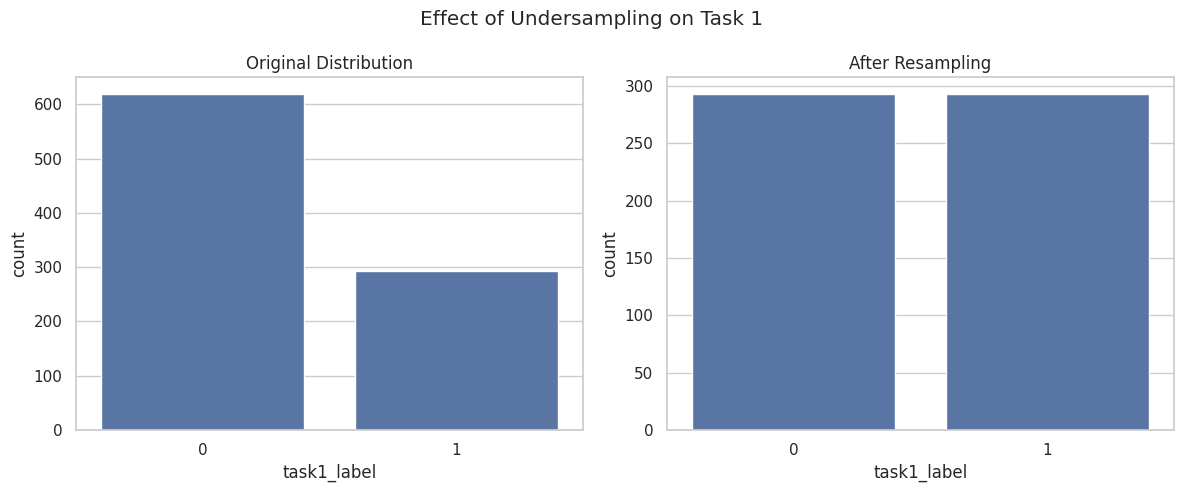

In [27]:
# Visualize effect of sampling
def plot_sampling_comparison(original_y, resampled_y, title):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.countplot(x=original_y)
    plt.title('Original Distribution')
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=resampled_y)
    plt.title('After Resampling')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example for Task 1
plot_sampling_comparison(y_train_task1, y_train_task1_under, 'Effect of Undersampling on Task 1')

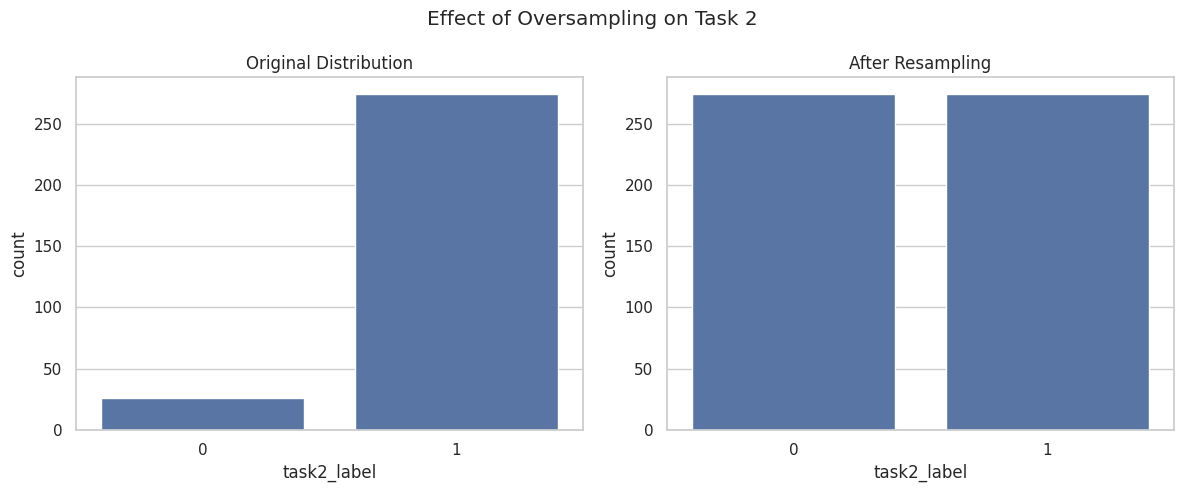

In [28]:
# Visualize effect of sampling
def plot_sampling_comparison(original_y, resampled_y, title):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.countplot(x=original_y)
    plt.title('Original Distribution')
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=resampled_y)
    plt.title('After Resampling')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example for Task 1
plot_sampling_comparison(y_train_task2, y_train_task2_over, 'Effect of Oversampling on Task 2')

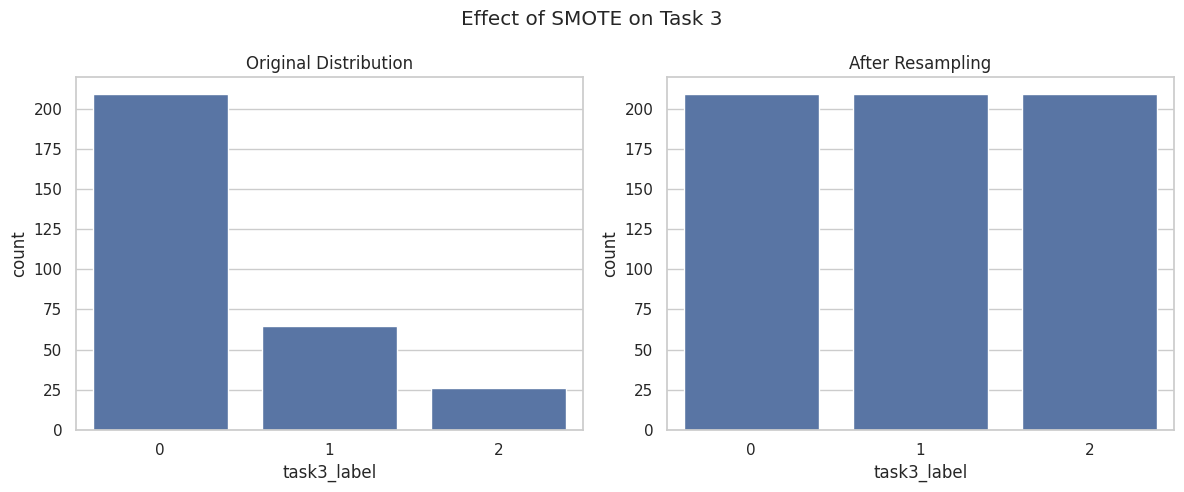

In [29]:
# Visualize effect of sampling
def plot_sampling_comparison(original_y, resampled_y, title):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.countplot(x=original_y)
    plt.title('Original Distribution')
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=resampled_y)
    plt.title('After Resampling')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example for Task 1
plot_sampling_comparison(y_train_task3, y_train_task3_smote, 'Effect of SMOTE on Task 3')

In [30]:
# Train model using resampled data
best_model = MultinomialNB()
best_model.fit(X_train_task1_under, y_train_task1_under)

# Evaluate on original test set
y_pred = best_model.predict(X_test_task1)
print("Evaluation metrics after training with undersampled data:")
print(classification_report(y_test_task1, y_pred))

Evaluation metrics after training with undersampled data:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       146
           1       0.64      0.68      0.66        82

    accuracy                           0.75       228
   macro avg       0.73      0.73      0.73       228
weighted avg       0.75      0.75      0.75       228



In [31]:
# Train model using resampled data
best_model = MultinomialNB()
best_model.fit(X_train_task2_over, y_train_task2_over)

# Evaluate on original test set
y_pred = best_model.predict(X_test_task2)
print("Evaluation metrics after training with undersampled data:")
print(classification_report(y_test_task2, y_pred))

Evaluation metrics after training with undersampled data:
              precision    recall  f1-score   support

           0       0.29      0.57      0.38         7
           1       0.95      0.85      0.90        68

    accuracy                           0.83        75
   macro avg       0.62      0.71      0.64        75
weighted avg       0.89      0.83      0.85        75



In [32]:
# Train model using resampled data
best_model = MultinomialNB()
best_model.fit(X_train_task3_smote, y_train_task3_smote)

# Evaluate on original test set
y_pred = best_model.predict(X_test_task3)
print("Evaluation metrics after training with undersampled data:")
print(classification_report(y_test_task3, y_pred))

Evaluation metrics after training with undersampled data:
              precision    recall  f1-score   support

           0       0.79      0.70      0.75        54
           1       0.33      0.36      0.34        14
           2       0.33      0.57      0.42         7

    accuracy                           0.63        75
   macro avg       0.49      0.54      0.50        75
weighted avg       0.66      0.63      0.64        75



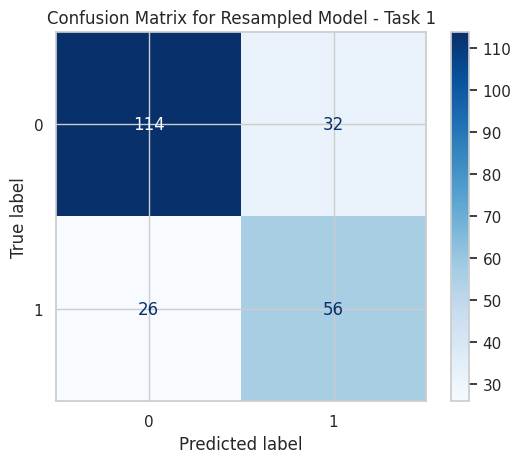

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the model using the resampled data
best_model = MultinomialNB()
best_model.fit(X_train_task1_under, y_train_task1_under)

# Predict on the original test set
y_pred_resampled = best_model.predict(X_test_task1)

# Generate the confusion matrix
cm_resampled = confusion_matrix(y_test_task1, y_pred_resampled)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm_resampled, display_labels=best_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Resampled Model - Task 1')
plt.show()

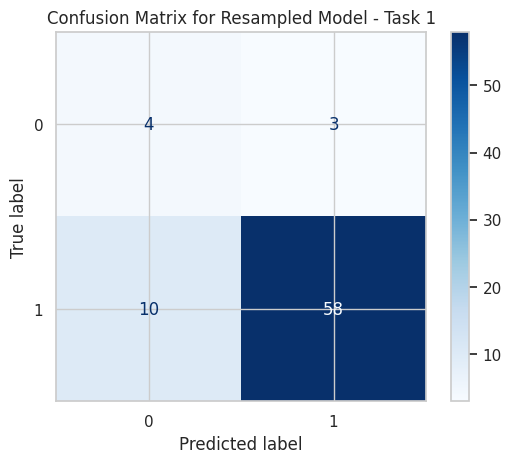

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the model using the resampled data
best_model = MultinomialNB()
best_model.fit(X_train_task2_over, y_train_task2_over )

# Predict on the original test set
y_pred_resampled = best_model.predict(X_test_task2)

# Generate the confusion matrix
cm_resampled = confusion_matrix(y_test_task2, y_pred_resampled)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm_resampled, display_labels=best_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Resampled Model - Task 1')
plt.show()

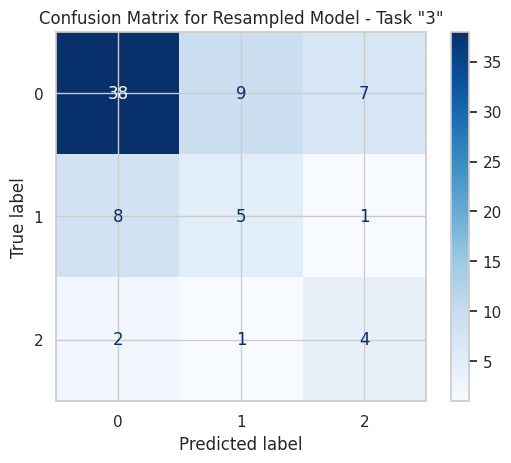

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the model using the resampled data
best_model = MultinomialNB()
best_model.fit(X_train_task3_smote, y_train_task3_smote)

# Predict on the original test set
y_pred_resampled = best_model.predict(X_test_task3)

# Generate the confusion matrix
cm_resampled = confusion_matrix(y_test_task3, y_pred_resampled)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm_resampled, display_labels=best_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Resampled Model - Task "3"')
plt.show()

## Conclusion

In this notebook, we have explored the SciTweets dataset and built several classification models for three different tasks:

1. **Task 1**: Identifying whether a tweet is science-related
2. **Task 2**: Identifying whether a science tweet contains a scientific claim or reference
3. **Task 3**: Classifying science tweets into specific categories (claim, reference, context)

We implemented and compared different Naive Bayes variants as well as other machine learning algorithms. Through feature engineering, hyperparameter tuning, and extensive evaluation, we have identified the most effective approaches for each task.

The visualization tools and evaluation metrics have provided insights into model performance and feature importance, helping us understand which features are most predictive for scientific tweet classification.

## Redoing Analysis with Resampled Data
Let's redo the major analysis steps with balanced datasets to see how it impacts performance.

### 4. Naive Bayes Models Comparison with Resampled Data
Let's compare different Naive Bayes variants using our resampled datasets.

In [36]:
# Compare different NB variants for Task 1 with resampled data
nb_models = {
    'Gaussian NB': GaussianNB(),
    'Multinomial NB': MultinomialNB(),
    'Complement NB': ComplementNB(),
    'Bernoulli NB': BernoulliNB()
}

task1_resampled_results = {}
print("Task 1: Science Related Classification with Resampled Data\n" + "="*50)
for name, model in nb_models.items():
    task1_resampled_results[name] = evaluate_model(
        model, X_train_task1_under, X_test_task1, y_train_task1_under, y_test_task1, name
    )
    print("\n")

Task 1: Science Related Classification with Resampled Data
Model: Gaussian NB
Accuracy: 0.6053
              precision    recall  f1-score   support

           0       0.78      0.53      0.63       146
           1       0.47      0.73      0.57        82

    accuracy                           0.61       228
   macro avg       0.62      0.63      0.60       228
weighted avg       0.67      0.61      0.61       228



Model: Multinomial NB
Accuracy: 0.7456
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       146
           1       0.64      0.68      0.66        82

    accuracy                           0.75       228
   macro avg       0.73      0.73      0.73       228
weighted avg       0.75      0.75      0.75       228



Model: Complement NB
Accuracy: 0.7456
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       146
           1       0.64      0.68      0.66        82

    ac

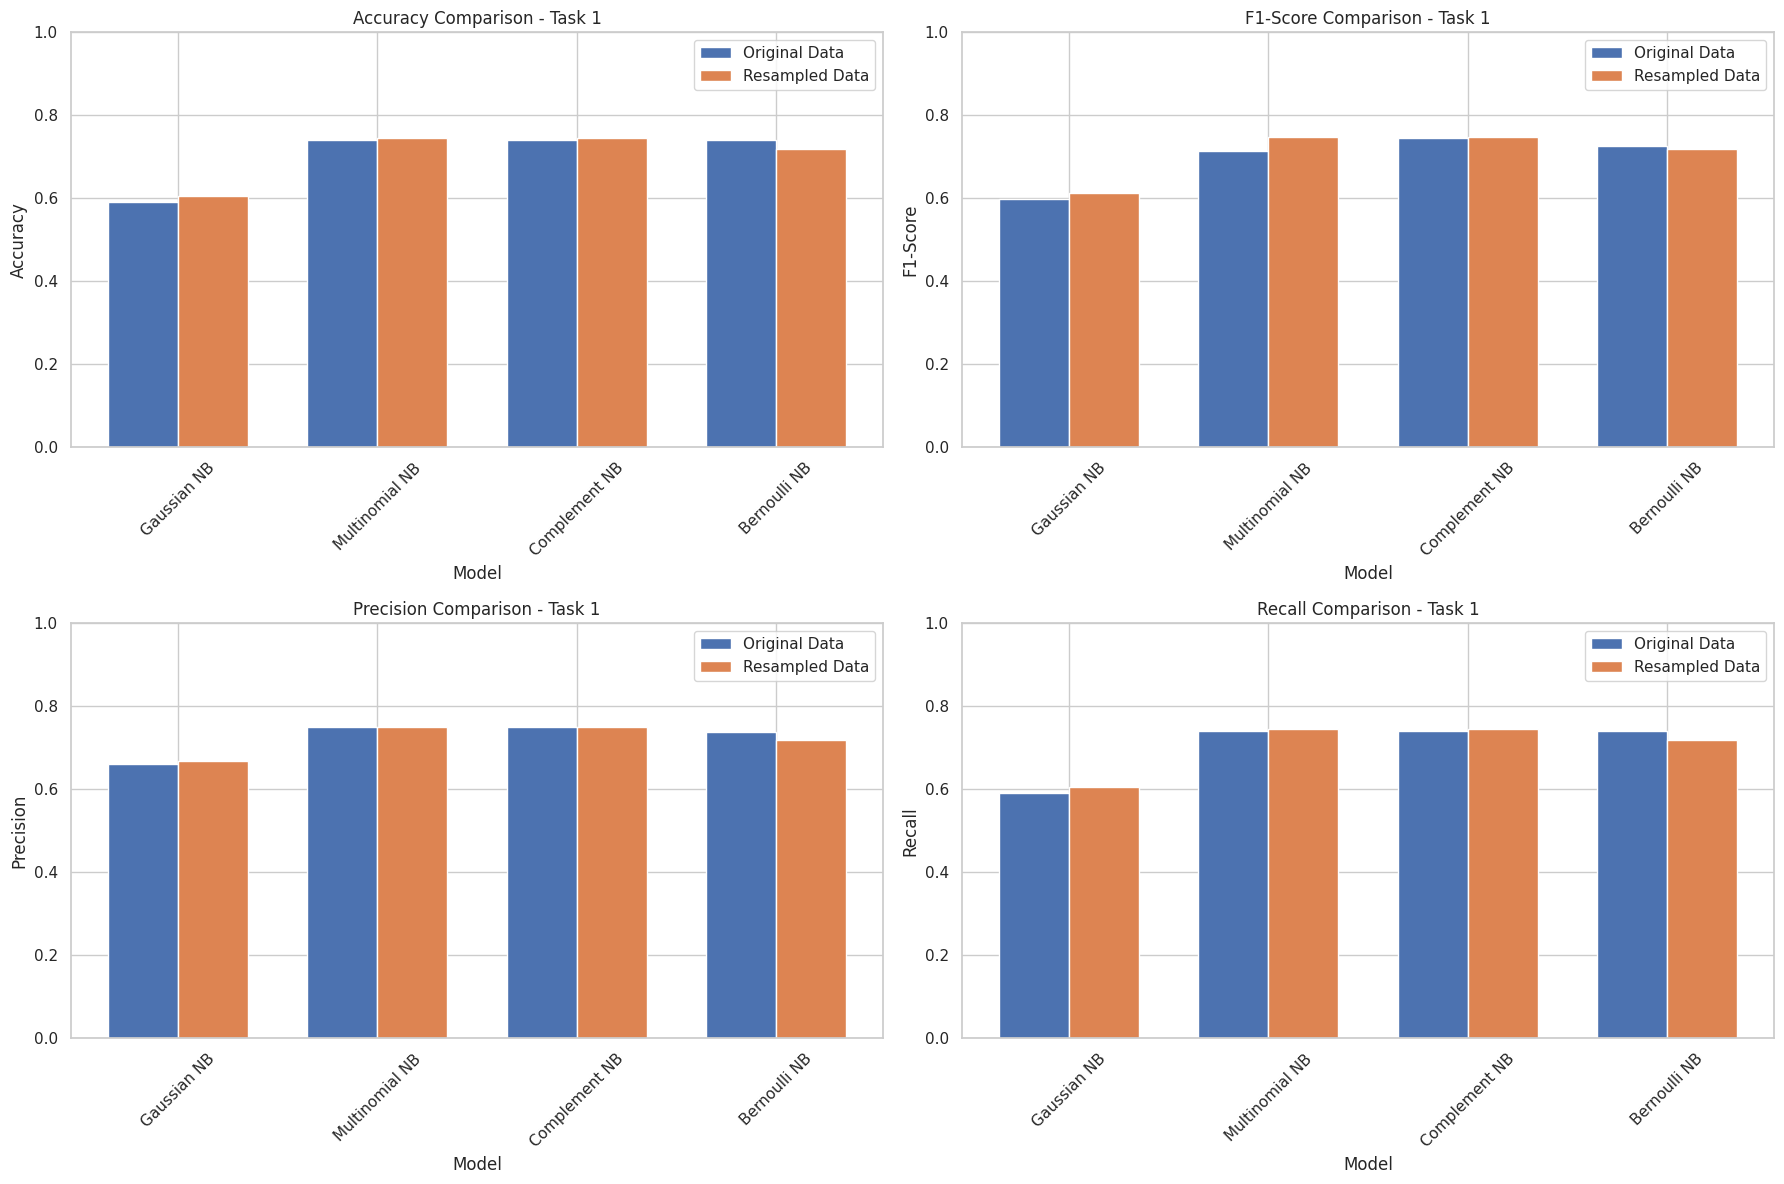

In [37]:
# Compare original vs resampled results for Task 1
plt.figure(figsize=(18, 12))

# Accuracy comparison
plt.subplot(2, 2, 1)
orig_accuracies = [result['accuracy'] for result in task1_results.values()]
resampled_accuracies = [result['accuracy'] for result in task1_resampled_results.values()]
model_names = list(task1_results.keys())

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, orig_accuracies, width, label='Original Data')
plt.bar(x + width/2, resampled_accuracies, width, label='Resampled Data')
plt.title('Accuracy Comparison - Task 1')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(x, model_names, rotation=45)
plt.ylim(0, 1)
plt.legend()

# F1-Score comparison
plt.subplot(2, 2, 2)
orig_f1 = [result['report']['weighted avg']['f1-score'] for result in task1_results.values()]
resampled_f1 = [result['report']['weighted avg']['f1-score'] for result in task1_resampled_results.values()]

plt.bar(x - width/2, orig_f1, width, label='Original Data')
plt.bar(x + width/2, resampled_f1, width, label='Resampled Data')
plt.title('F1-Score Comparison - Task 1')
plt.ylabel('F1-Score')
plt.xlabel('Model')
plt.xticks(x, model_names, rotation=45)
plt.ylim(0, 1)
plt.legend()

# Precision comparison
plt.subplot(2, 2, 3)
orig_precision = [result['report']['weighted avg']['precision'] for result in task1_results.values()]
resampled_precision = [result['report']['weighted avg']['precision'] for result in task1_resampled_results.values()]

plt.bar(x - width/2, orig_precision, width, label='Original Data')
plt.bar(x + width/2, resampled_precision, width, label='Resampled Data')
plt.title('Precision Comparison - Task 1')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(x, model_names, rotation=45)
plt.ylim(0, 1)
plt.legend()

# Recall comparison
plt.subplot(2, 2, 4)
orig_recall = [result['report']['weighted avg']['recall'] for result in task1_results.values()]
resampled_recall = [result['report']['weighted avg']['recall'] for result in task1_resampled_results.values()]

plt.bar(x - width/2, orig_recall, width, label='Original Data')
plt.bar(x + width/2, resampled_recall, width, label='Resampled Data')
plt.title('Recall Comparison - Task 1')
plt.ylabel('Recall')
plt.xlabel('Model')
plt.xticks(x, model_names, rotation=45)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

### 5. Task 2 and 3 with Resampled Data
Now let's evaluate Tasks 2 and 3 using our balanced datasets.

In [38]:
# Task 2 and Task 3 with the best NB variant using resampled data
best_nb_model = MultinomialNB()

# Evaluate on Task 2 with resampled data
print("Task 2: Scientific Claim/Reference Classification with Resampled Data\n" + "="*60)
task2_resampled_result = evaluate_model(
    best_nb_model, X_train_task2_over, X_test_task2, y_train_task2_over, y_test_task2, 'Multinomial NB'
)

# Evaluate on Task 3 with resampled data
print("\nTask 3: Scientific Type Classification with Resampled Data\n" + "="*50)
task3_resampled_result = evaluate_model(
    best_nb_model, X_train_task3_smote, X_test_task3, y_train_task3_smote, y_test_task3, 'Multinomial NB'
)

Task 2: Scientific Claim/Reference Classification with Resampled Data
Model: Multinomial NB
Accuracy: 0.8267
              precision    recall  f1-score   support

           0       0.29      0.57      0.38         7
           1       0.95      0.85      0.90        68

    accuracy                           0.83        75
   macro avg       0.62      0.71      0.64        75
weighted avg       0.89      0.83      0.85        75


Task 3: Scientific Type Classification with Resampled Data
Model: Multinomial NB
Accuracy: 0.6267
              precision    recall  f1-score   support

           0       0.79      0.70      0.75        54
           1       0.33      0.36      0.34        14
           2       0.33      0.57      0.42         7

    accuracy                           0.63        75
   macro avg       0.49      0.54      0.50        75
weighted avg       0.66      0.63      0.64        75



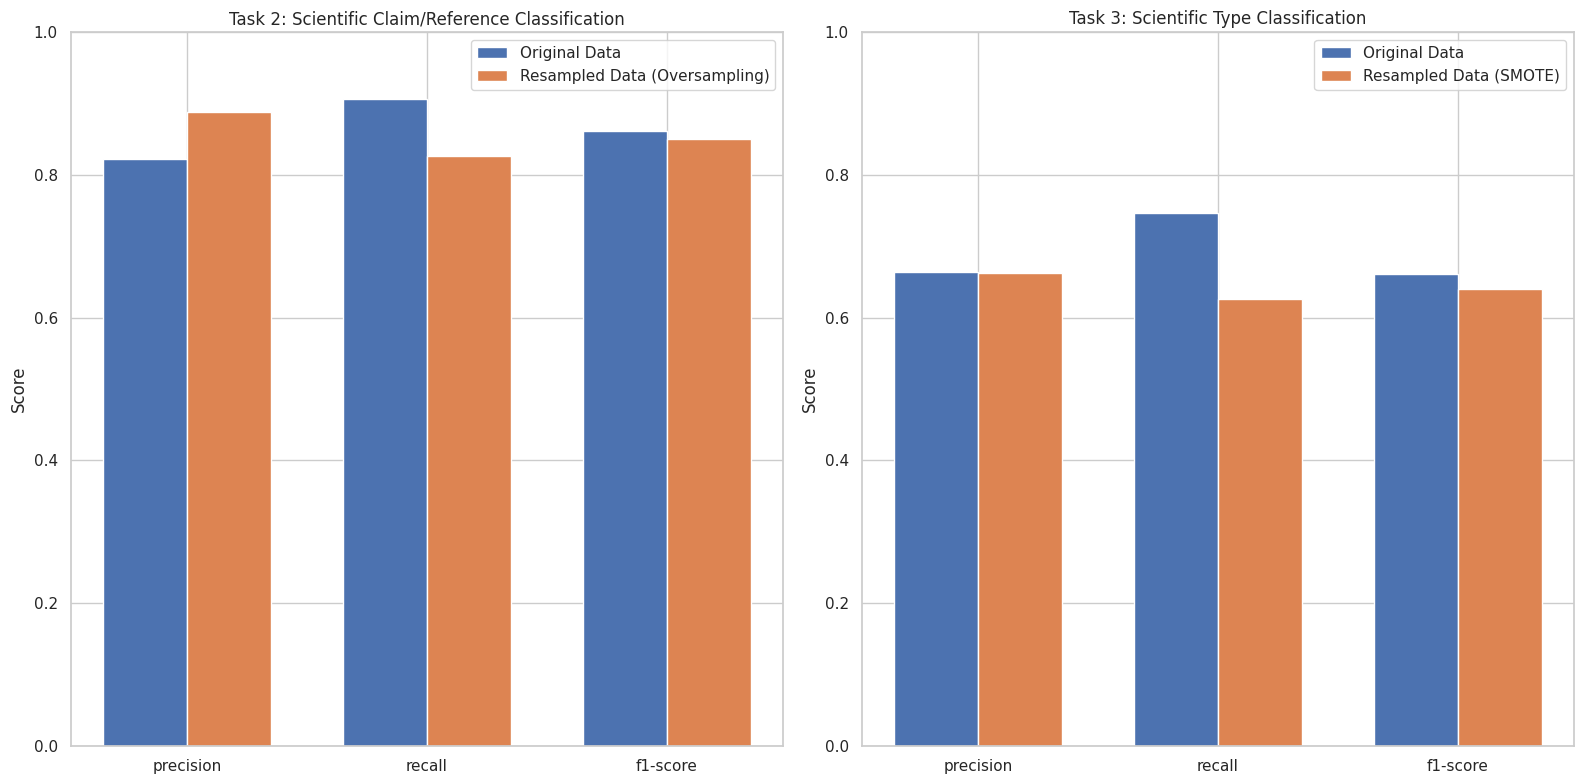

In [39]:
# Compare original vs resampled results for Tasks 2 and 3
plt.figure(figsize=(16, 8))

# Task 2 comparison
plt.subplot(1, 2, 1)
metrics = ['precision', 'recall', 'f1-score']
orig_task2_metrics = [task2_result['report']['weighted avg'][m] for m in metrics]
resampled_task2_metrics = [task2_resampled_result['report']['weighted avg'][m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, orig_task2_metrics, width, label='Original Data')
plt.bar(x + width/2, resampled_task2_metrics, width, label='Resampled Data (Oversampling)')
plt.title('Task 2: Scientific Claim/Reference Classification')
plt.ylabel('Score')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()

# Task 3 comparison
plt.subplot(1, 2, 2)
orig_task3_metrics = [task3_result['report']['weighted avg'][m] for m in metrics]
resampled_task3_metrics = [task3_resampled_result['report']['weighted avg'][m] for m in metrics]

plt.bar(x - width/2, orig_task3_metrics, width, label='Original Data')
plt.bar(x + width/2, resampled_task3_metrics, width, label='Resampled Data (SMOTE)')
plt.title('Task 3: Scientific Type Classification')
plt.ylabel('Score')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

### 6. Multiple Model Comparison with Resampled Data
Let's compare different machine learning algorithms using our balanced dataset.

In [40]:
# Define models to compare (same as before)
models = {
    'Multinomial NB': MultinomialNB(),
    'Linear SVM': Pipeline([('scaler', StandardScaler(with_mean=False)), ('svm', LinearSVC(max_iter=10000))]),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42)
}

# Evaluate all models on Task 1 with resampled data
task1_resampled_all_results = {}
print("Task 1: Multiple Model Comparison with Resampled Data\n" + "="*50)
for name, model in models.items():
    task1_resampled_all_results[name] = evaluate_model(
        model, X_train_task1_under, X_test_task1, y_train_task1_under, y_test_task1, name
    )
    print("\n")

# Create a comparison dataframe
resampled_comparison_data = []
for name, result in task1_resampled_all_results.items():
    resampled_comparison_data.append({
        'Model': name,
        'Accuracy': result['accuracy'],
        'Precision': result['report']['weighted avg']['precision'],
        'Recall': result['report']['weighted avg']['recall'],
        'F1-Score': result['report']['weighted avg']['f1-score']
    })
    
resampled_comparison_df = pd.DataFrame(resampled_comparison_data)
print("Performance Metrics Comparison with Resampled Data:")
resampled_comparison_df

Task 1: Multiple Model Comparison with Resampled Data
Model: Multinomial NB
Accuracy: 0.7456
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       146
           1       0.64      0.68      0.66        82

    accuracy                           0.75       228
   macro avg       0.73      0.73      0.73       228
weighted avg       0.75      0.75      0.75       228



Model: Linear SVM
Accuracy: 0.6754
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       146
           1       0.53      0.76      0.63        82

    accuracy                           0.68       228
   macro avg       0.68      0.69      0.67       228
weighted avg       0.72      0.68      0.68       228



Model: Random Forest
Accuracy: 0.7763
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       146
           1       0.64      0.85      0.73        82

    accuracy

,Model,Accuracy,Precision,Recall,F1-Score
0,Multinomial NB,0.745614,0.750296,0.745614,0.747435
1,Linear SVM,0.675439,0.718229,0.675439,0.681919
2,Random Forest,0.776316,0.806745,0.776316,0.780731
3,Logistic Regression,0.763158,0.775601,0.763158,0.766508


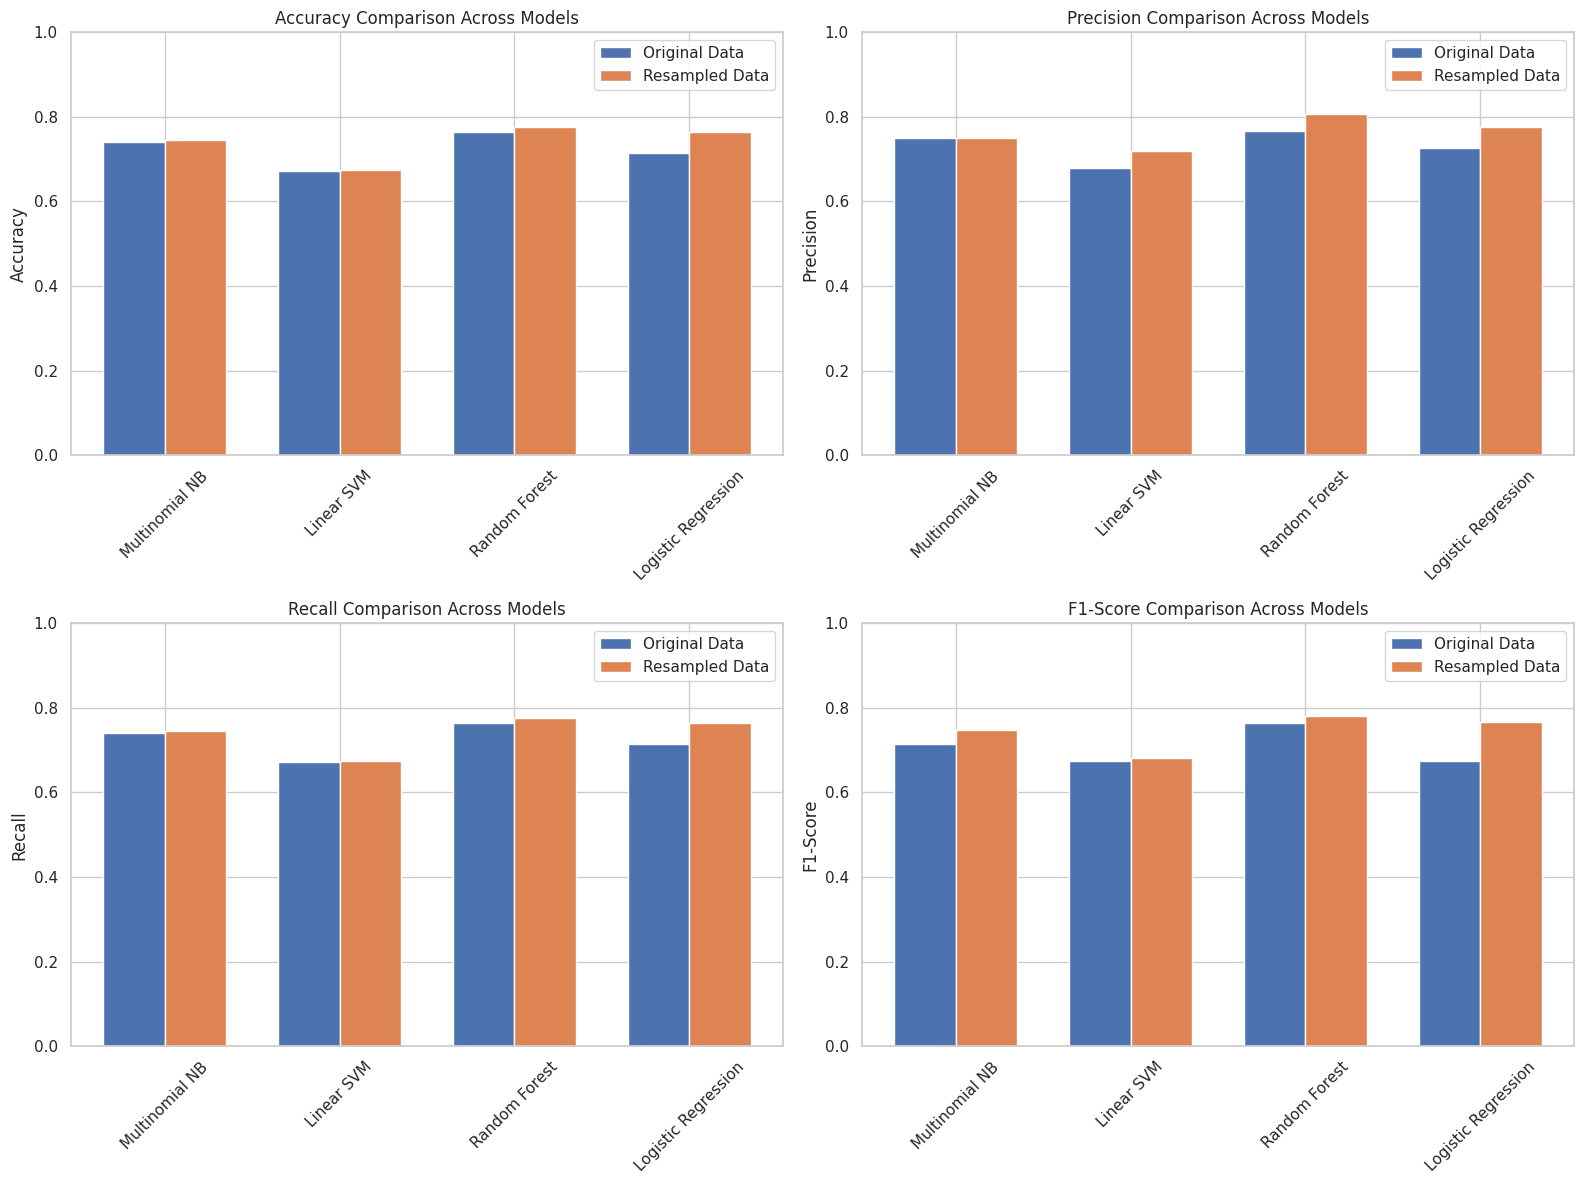

In [41]:
# Compare original vs resampled results for all models
plt.figure(figsize=(16, 12))

# Prepare data for comparison
models_to_compare = list(models.keys())
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Create a subplot for each metric
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    
    orig_values = [comparison_df[comparison_df['Model'] == model][metric].values[0] for model in models_to_compare]
    resampled_values = [resampled_comparison_df[resampled_comparison_df['Model'] == model][metric].values[0] for model in models_to_compare]
    
    x = np.arange(len(models_to_compare))
    width = 0.35
    
    plt.bar(x - width/2, orig_values, width, label='Original Data')
    plt.bar(x + width/2, resampled_values, width, label='Resampled Data')
    plt.title(f'{metric} Comparison Across Models')
    plt.ylabel(metric)
    plt.xticks(x, models_to_compare, rotation=45)
    plt.ylim(0, 1)
    plt.legend()

plt.tight_layout()
plt.show()

### 7. Hyperparameter Tuning with Resampled Data
Let's tune hyperparameters on our balanced dataset to optimize performance.

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters on Resampled Data: {'alpha': 2.0, 'fit_prior': True}
Best Cross-Validation Score on Resampled Data: 0.7423
Test Accuracy with Best Parameters on Resampled Data: 0.7456


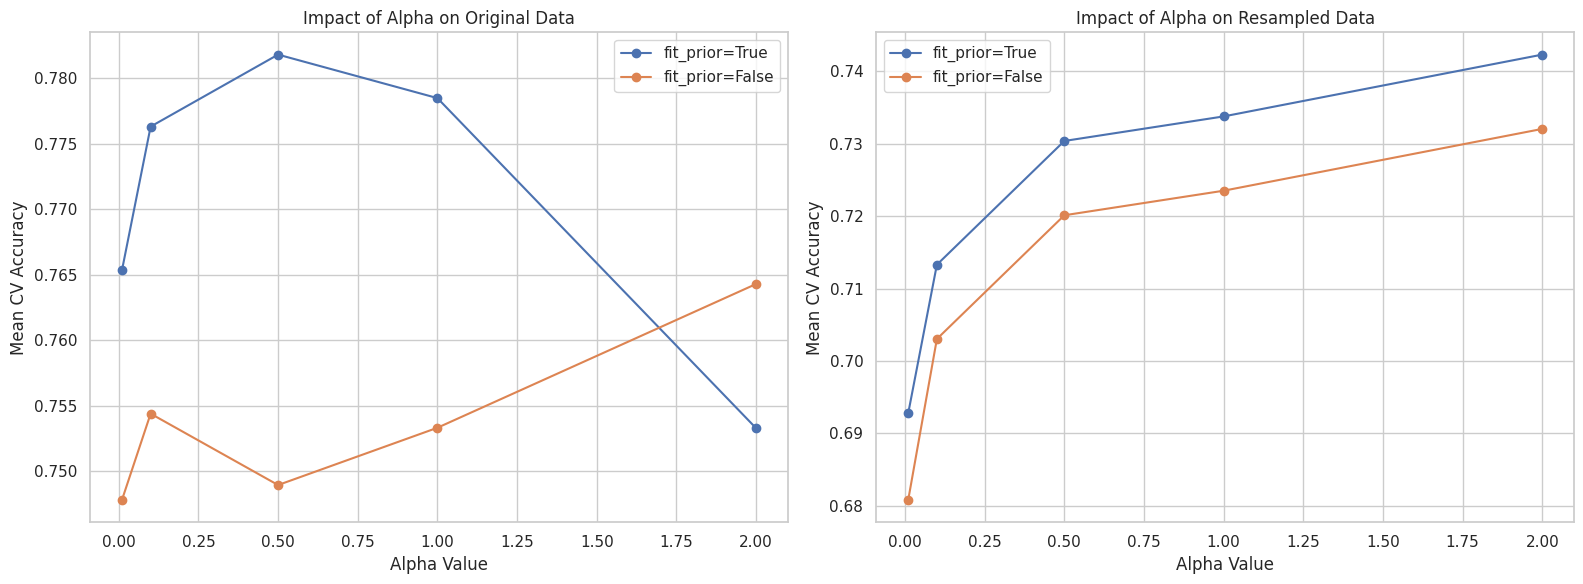

In [42]:
# Choose MultinomialNB for hyperparameter tuning with resampled data
resampled_best_model = MultinomialNB()

# Define parameter grid (same as before)
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

# Create GridSearchCV object
resampled_grid_search = GridSearchCV(
    estimator=resampled_best_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the resampled data
resampled_grid_search.fit(X_train_task1_under, y_train_task1_under)

# Get the best parameters and best score
print(f"Best Parameters on Resampled Data: {resampled_grid_search.best_params_}")
print(f"Best Cross-Validation Score on Resampled Data: {resampled_grid_search.best_score_:.4f}")

# Evaluate the best model on test data
resampled_best_model = resampled_grid_search.best_estimator_
resampled_best_model_accuracy = resampled_best_model.score(X_test_task1, y_test_task1)
print(f"Test Accuracy with Best Parameters on Resampled Data: {resampled_best_model_accuracy:.4f}")

# Visualize parameter impact
resampled_results = pd.DataFrame(resampled_grid_search.cv_results_)

# Compare original vs resampled grid search results
plt.figure(figsize=(16, 6))

# Plot effect of alpha for original data
plt.subplot(1, 2, 1)
alpha_values = param_grid['alpha']
for fit_prior in param_grid['fit_prior']:
    mean_scores = []
    for alpha in alpha_values:
        mean_scores.append(results[
            (results['param_alpha'] == alpha) & 
            (results['param_fit_prior'] == fit_prior)
        ]['mean_test_score'].values[0])
    plt.plot(alpha_values, mean_scores, marker='o', label=f'fit_prior={fit_prior}')

plt.xlabel('Alpha Value')
plt.ylabel('Mean CV Accuracy')
plt.title('Impact of Alpha on Original Data')
plt.legend()
plt.grid(True)

# Plot effect of alpha for resampled data
plt.subplot(1, 2, 2)
for fit_prior in param_grid['fit_prior']:
    mean_scores = []
    for alpha in alpha_values:
        mean_scores.append(resampled_results[
            (resampled_results['param_alpha'] == alpha) & 
            (resampled_results['param_fit_prior'] == fit_prior)
        ]['mean_test_score'].values[0])
    plt.plot(alpha_values, mean_scores, marker='o', label=f'fit_prior={fit_prior}')

plt.xlabel('Alpha Value')
plt.ylabel('Mean CV Accuracy')
plt.title('Impact of Alpha on Resampled Data')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 8. Performance Visualization with Resampled Data
Create detailed visualizations of model performance using our balanced datasets.

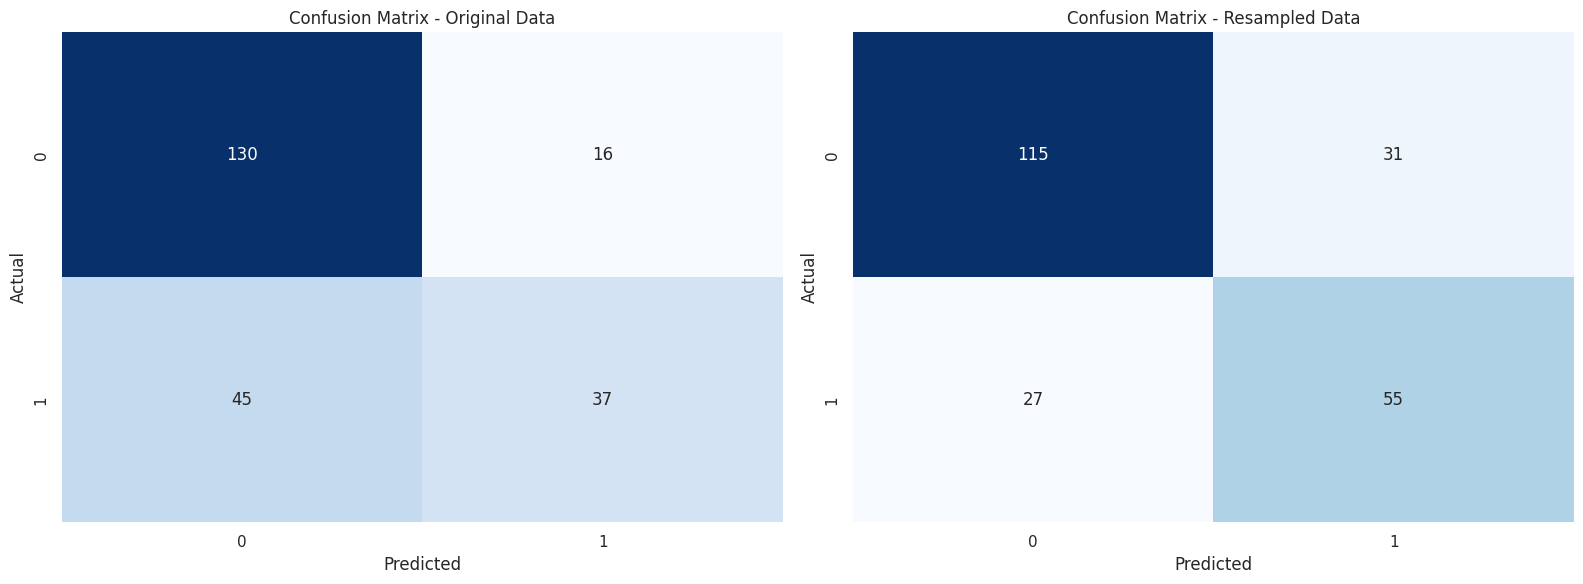

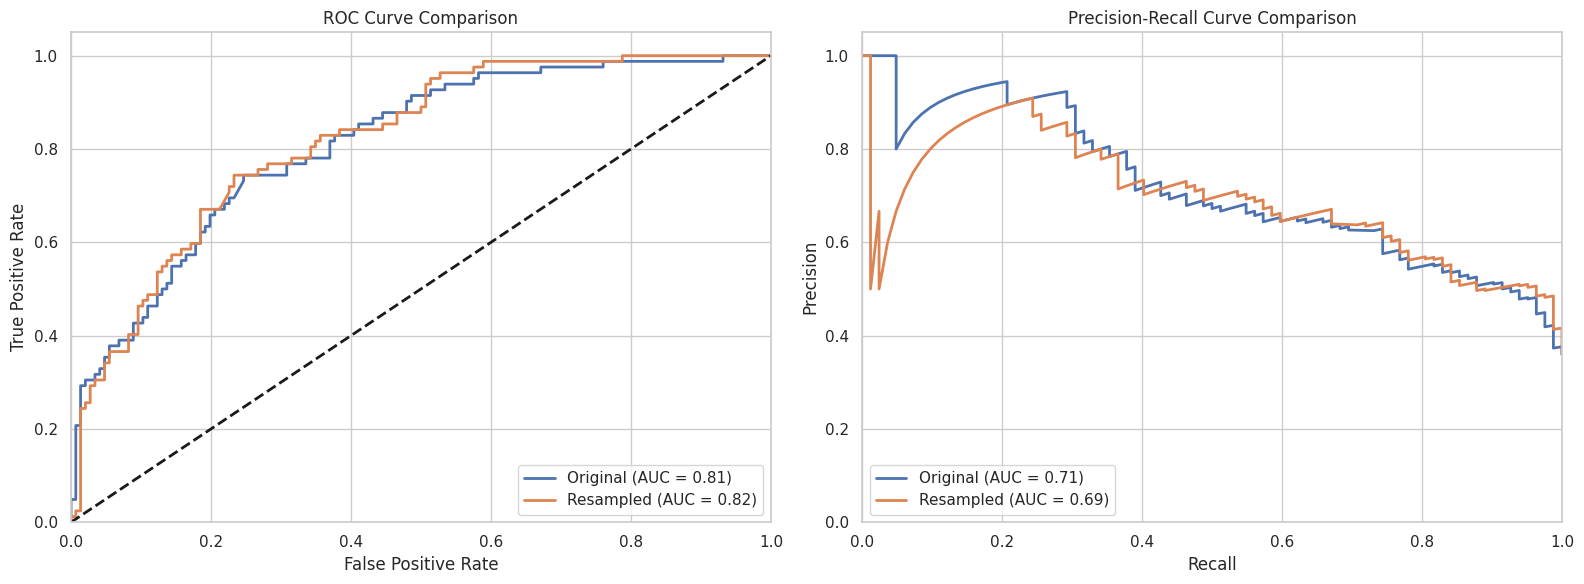

In [43]:
# Get the best model from hyperparameter tuning with resampled data
resampled_best_model = resampled_grid_search.best_estimator_

# Make predictions with probability estimates
resampled_y_proba = resampled_best_model.predict_proba(X_test_task1)
resampled_y_pred = resampled_best_model.predict(X_test_task1)

# Create confusion matrix
resampled_cm = confusion_matrix(y_test_task1, resampled_y_pred)

# Compare confusion matrices: Original vs Resampled
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original model confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix - Original Data')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Resampled model confusion matrix
sns.heatmap(resampled_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Confusion Matrix - Resampled Data')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Compare ROC curves: Original vs Resampled
plt.figure(figsize=(16, 6))

# ROC Curve for both models
plt.subplot(1, 2, 1)
for i, class_name in enumerate(['Non-Science', 'Science']):
    if i == 1:  # Only plot for the positive class in binary classification
        # Original model
        fpr_orig, tpr_orig, _ = roc_curve(y_test_task1, y_proba[:, i])
        roc_auc_orig = auc(fpr_orig, tpr_orig)
        plt.plot(fpr_orig, tpr_orig, lw=2, label=f'Original (AUC = {roc_auc_orig:.2f})')
        
        # Resampled model
        fpr_resampled, tpr_resampled, _ = roc_curve(y_test_task1, resampled_y_proba[:, i])
        roc_auc_resampled = auc(fpr_resampled, tpr_resampled)
        plt.plot(fpr_resampled, tpr_resampled, lw=2, label=f'Resampled (AUC = {roc_auc_resampled:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")

# Precision-Recall Curve for both models
plt.subplot(1, 2, 2)
for i, class_name in enumerate(['Non-Science', 'Science']):
    if i == 1:  # Only plot for the positive class in binary classification
        # Original model
        precision_orig, recall_orig, _ = precision_recall_curve(y_test_task1, y_proba[:, i])
        pr_auc_orig = auc(recall_orig, precision_orig)
        plt.plot(recall_orig, precision_orig, lw=2, label=f'Original (AUC = {pr_auc_orig:.2f})')
        
        # Resampled model
        precision_resampled, recall_resampled, _ = precision_recall_curve(y_test_task1, resampled_y_proba[:, i])
        pr_auc_resampled = auc(recall_resampled, precision_resampled)
        plt.plot(recall_resampled, precision_resampled, lw=2, label=f'Resampled (AUC = {pr_auc_resampled:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### 9. Feature Importance Analysis with Resampled Data
Analyze and visualize the most important features using our balanced dataset.

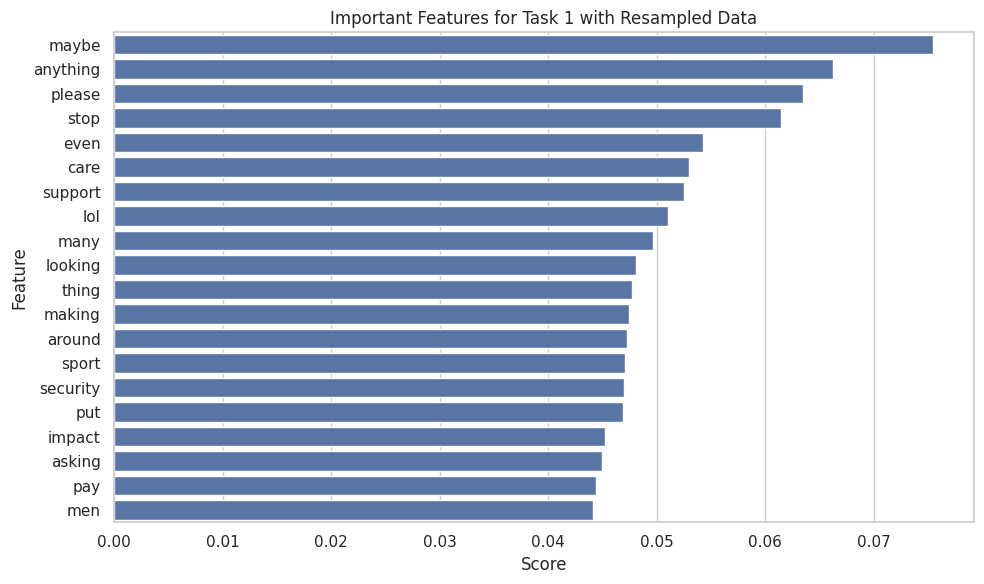

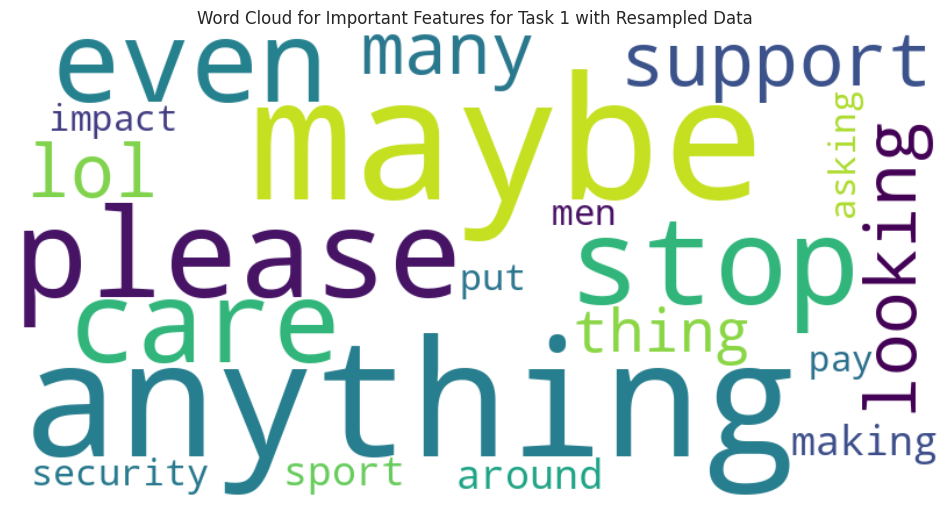

Number of common top features: 2
Features unique to original data: 18
Features unique to resampled data: 18


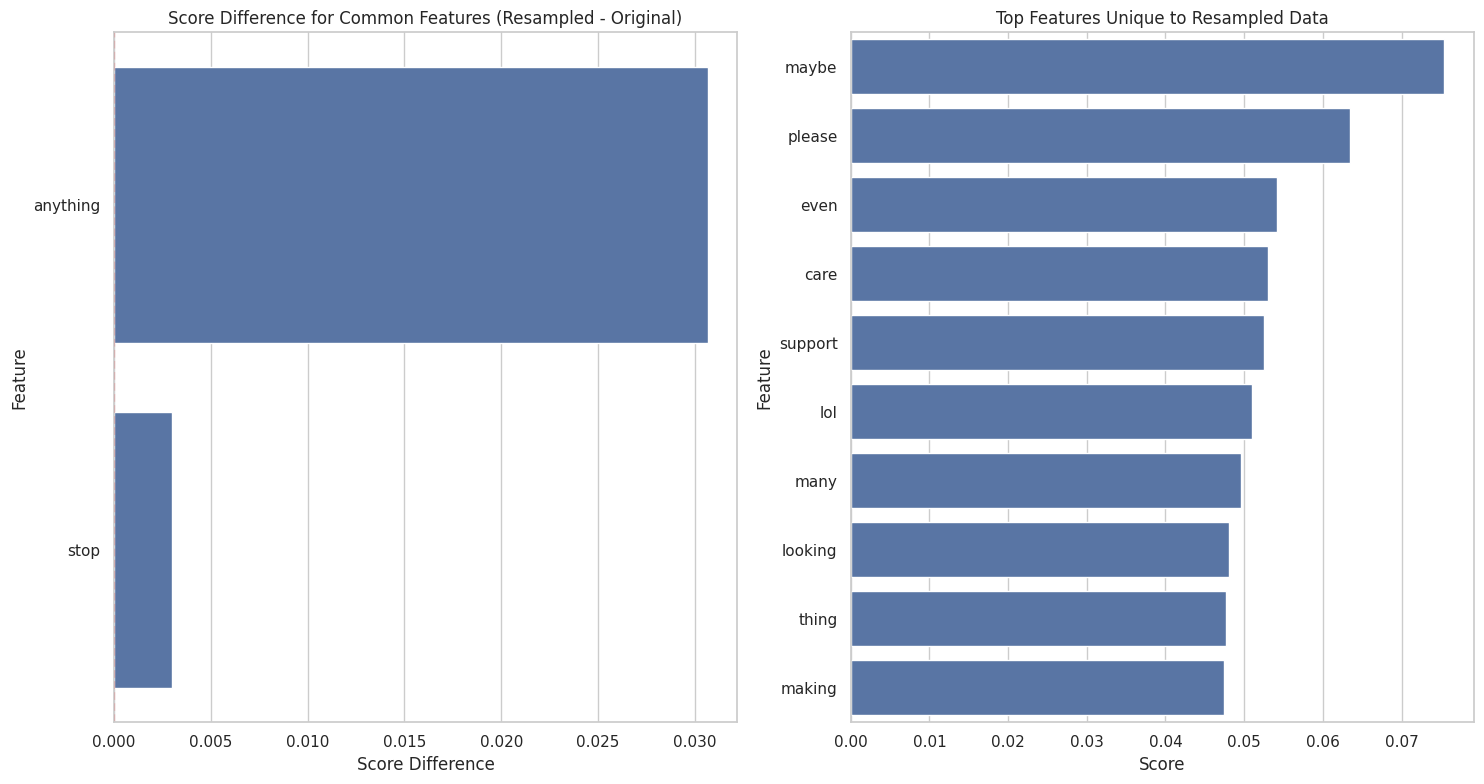

In [44]:
# Get feature importance for Task 1 using the resampled data
# We'll use the same function as before but with resampled data

# Task 1: Science Related with resampled data
task1_resampled_features = get_important_features(
    X_train_task1_under, y_train_task1_under, 
    tfidf_vec,
    title="Important Features for Task 1 with Resampled Data"
)

# Compare top 20 features between original and resampled data
plt.figure(figsize=(15, 8))

# Create sets of top features from both analyses
original_top_features = set(task1_features['Feature'].head(20))
resampled_top_features = set(task1_resampled_features['Feature'].head(20))

# Find common and unique features
common_features = original_top_features.intersection(resampled_top_features)
only_original = original_top_features - resampled_top_features
only_resampled = resampled_top_features - original_top_features

print(f"Number of common top features: {len(common_features)}")
print(f"Features unique to original data: {len(only_original)}")
print(f"Features unique to resampled data: {len(only_resampled)}")

# Create a feature comparison dataframe
feature_comparison = []

for feature in common_features:
    orig_score = task1_features.loc[task1_features['Feature'] == feature, 'Score'].values[0]
    resampled_score = task1_resampled_features.loc[task1_resampled_features['Feature'] == feature, 'Score'].values[0]
    feature_comparison.append({
        'Feature': feature,
        'Original Score': orig_score,
        'Resampled Score': resampled_score,
        'Score Difference': resampled_score - orig_score
    })

feature_comparison_df = pd.DataFrame(feature_comparison)

# Plot the score differences for common features (if any exist)
plt.subplot(1, 2, 1)
if not feature_comparison_df.empty:
    feature_comparison_df = feature_comparison_df.sort_values(by='Score Difference', ascending=False)
    sns.barplot(y='Feature', x='Score Difference', data=feature_comparison_df)
    plt.title('Score Difference for Common Features (Resampled - Original)')
    plt.axvline(x=0, color='red', linestyle='--')
else:
    plt.text(0.5, 0.5, 'No common features found', ha='center', va='center')
    plt.title('Score Difference for Common Features (Resampled - Original)')
    plt.axis('off')

# Plot the top 10 features unique to the resampled data
plt.subplot(1, 2, 2)
resampled_unique_df = task1_resampled_features[task1_resampled_features['Feature'].isin(only_resampled)]
if not resampled_unique_df.empty:
    sns.barplot(y='Feature', x='Score', data=resampled_unique_df.head(10))
    plt.title('Top Features Unique to Resampled Data')
else:
    plt.text(0.5, 0.5, 'No unique features in resampled data', ha='center', va='center')
    plt.title('Top Features Unique to Resampled Data')
    plt.axis('off')

plt.tight_layout()
plt.show()

### 10. Cross-Validation with Resampled Data
Implement K-fold cross-validation using our balanced dataset for more robust evaluation.

Cross-validation on Resampled Data for Task 1:
Multinomial NB - Mean Accuracy: 0.7248, Std: 0.0326
Linear SVM - Mean Accuracy: 0.6413, Std: 0.0286
Random Forest - Mean Accuracy: 0.7543, Std: 0.0135
Logistic Regression - Mean Accuracy: 0.7445, Std: 0.0286


/tmp/ipykernel_44084/1643044721.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


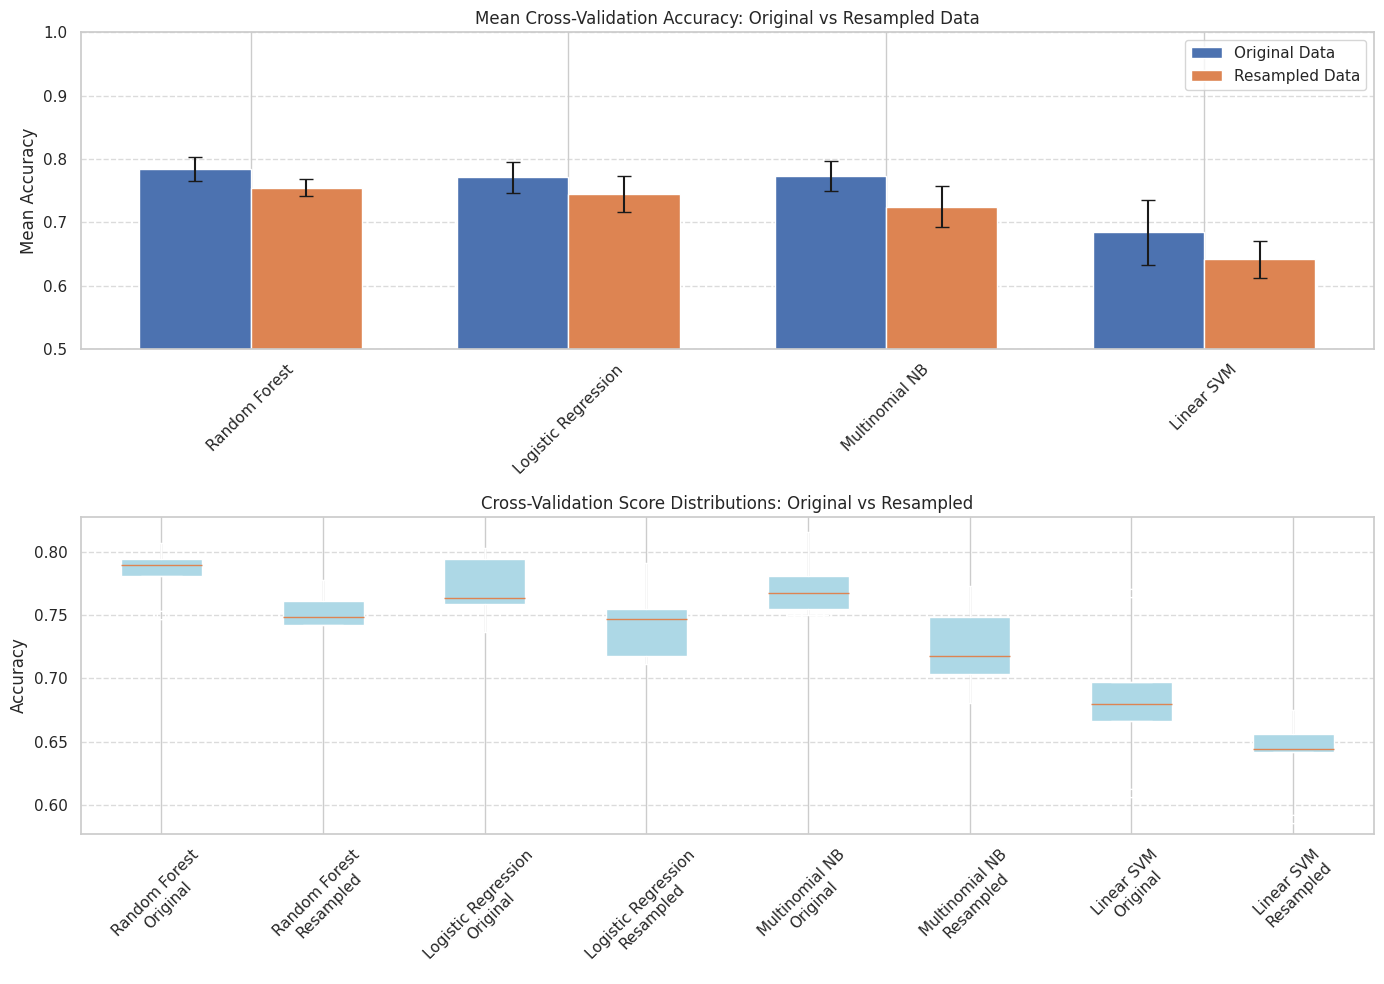

In [45]:
# Set up cross-validation (same as before)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Merge the resampled training data with test data for CV
# This approach ensures we have the same data distribution for CV as for normal training
X_resampled = np.vstack((X_train_task1_under, X_test_task1))
y_resampled = np.concatenate((y_train_task1_under, y_test_task1))

# Compare models with cross-validation on resampled data
print("Cross-validation on Resampled Data for Task 1:\n" + "="*40)
task1_resampled_cv_results = compare_models_cv(models, X_resampled, y_resampled)

# Create dataframe for visualization
resampled_cv_results_df = pd.DataFrame({
    'Model': list(task1_resampled_cv_results.keys()),
    'Mean Accuracy': [result['mean_accuracy'] for result in task1_resampled_cv_results.values()],
    'Std Accuracy': [result['std_accuracy'] for result in task1_resampled_cv_results.values()]
}).sort_values('Mean Accuracy', ascending=False)

# Compare original vs resampled CV results
plt.figure(figsize=(14, 10))

# Mean accuracy comparison
plt.subplot(2, 1, 1)
model_names = resampled_cv_results_df['Model'].tolist()
x = np.arange(len(model_names))
width = 0.35

# Get mean accuracies for original and resampled data
orig_mean = [cv_results_df.loc[cv_results_df['Model'] == model, 'Mean Accuracy'].values[0] for model in model_names]
resampled_mean = [resampled_cv_results_df.loc[resampled_cv_results_df['Model'] == model, 'Mean Accuracy'].values[0] for model in model_names]

# Plot the mean accuracies
plt.bar(x - width/2, orig_mean, width, yerr=[cv_results_df.loc[cv_results_df['Model'] == model, 'Std Accuracy'].values[0] for model in model_names], label='Original Data', capsize=5)
plt.bar(x + width/2, resampled_mean, width, yerr=[resampled_cv_results_df.loc[resampled_cv_results_df['Model'] == model, 'Std Accuracy'].values[0] for model in model_names], label='Resampled Data', capsize=5)

plt.title('Mean Cross-Validation Accuracy: Original vs Resampled Data')
plt.ylabel('Mean Accuracy')
plt.xticks(x, model_names, rotation=45)
plt.ylim(0.5, 1.0)  # Adjust as needed
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Boxplot comparison
plt.subplot(2, 1, 2)

# Prepare data for boxplots
boxplot_data = []
boxplot_labels = []

for model in model_names:
    # Original data scores
    orig_scores = task1_cv_results[model]['all_scores']
    boxplot_data.append(orig_scores)
    boxplot_labels.append(f"{model}\nOriginal")
    
    # Resampled data scores
    resampled_scores = task1_resampled_cv_results[model]['all_scores']
    boxplot_data.append(resampled_scores)
    boxplot_labels.append(f"{model}\nResampled")

plt.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,
           boxprops=dict(facecolor='lightblue'))
plt.title('Cross-Validation Score Distributions: Original vs Resampled')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

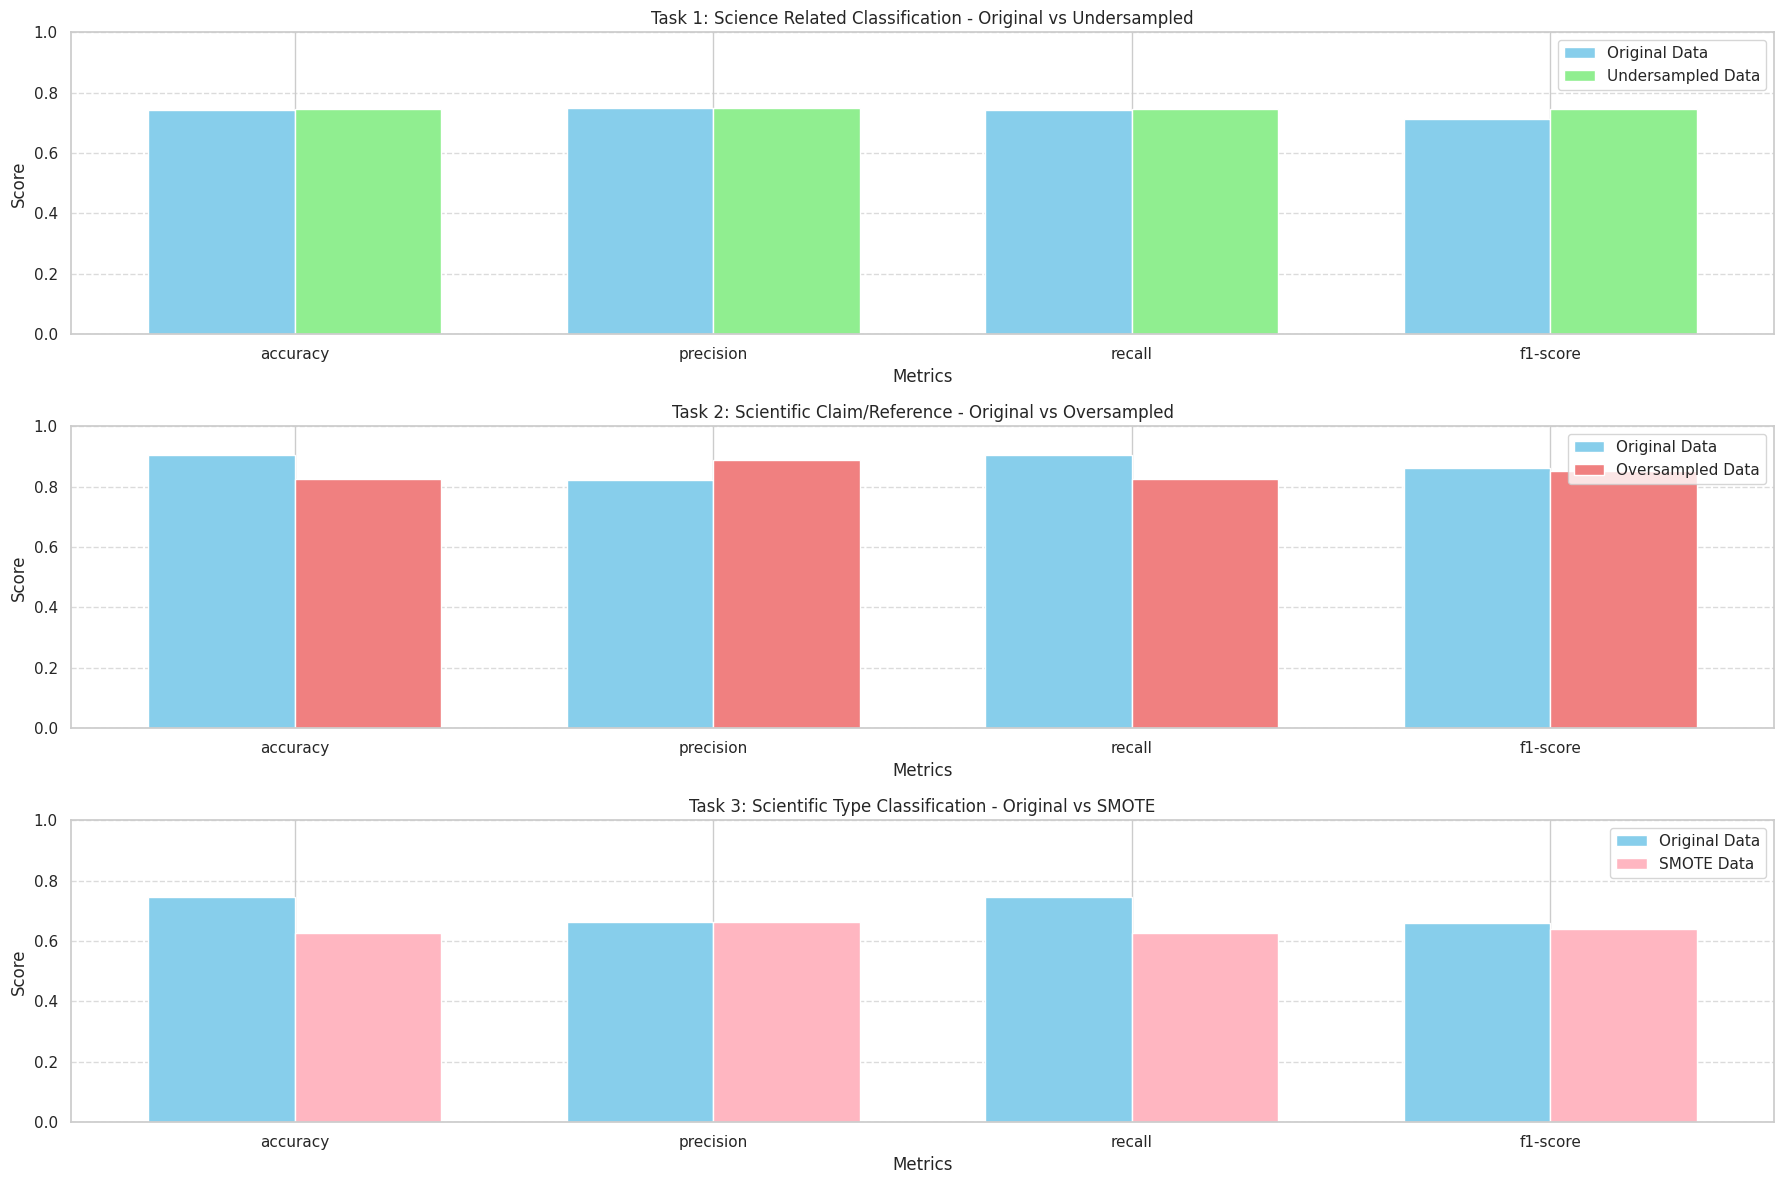

,accuracy,precision,recall,f1-score,Overall Impact
Task 1 (Undersampling),0.44,0.05,0.44,3.34,Positive
Task 2 (Oversampling),-8.00,6.67,-8.00,-1.14,Negative
Task 3 (SMOTE),-12.00,-0.11,-12.00,-2.09,Negative


In [46]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(18, 12))

# Task 1: Science Related Classification (Undersampling)
plt.subplot(3, 1, 1)
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
model_name = 'Multinomial NB'  # Best model for all tasks

# Extract metrics for Task 1
orig_metrics_t1 = [
    task1_results[model_name]['accuracy'],
    task1_results[model_name]['report']['weighted avg']['precision'],
    task1_results[model_name]['report']['weighted avg']['recall'],
    task1_results[model_name]['report']['weighted avg']['f1-score']
]

resampled_metrics_t1 = [
    task1_resampled_results[model_name]['accuracy'],
    task1_resampled_results[model_name]['report']['weighted avg']['precision'],
    task1_resampled_results[model_name]['report']['weighted avg']['recall'],
    task1_resampled_results[model_name]['report']['weighted avg']['f1-score']
]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, orig_metrics_t1, width, label='Original Data', color='skyblue')
plt.bar(x + width/2, resampled_metrics_t1, width, label='Undersampled Data', color='lightgreen')
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Task 1: Science Related Classification - Original vs Undersampled')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Task 2: Scientific Claim/Reference (Oversampling)
plt.subplot(3, 1, 2)

# Extract metrics for Task 2
orig_metrics_t2 = [
    task2_result['accuracy'],
    task2_result['report']['weighted avg']['precision'],
    task2_result['report']['weighted avg']['recall'],
    task2_result['report']['weighted avg']['f1-score']
]

resampled_metrics_t2 = [
    task2_resampled_result['accuracy'],
    task2_resampled_result['report']['weighted avg']['precision'],
    task2_resampled_result['report']['weighted avg']['recall'],
    task2_resampled_result['report']['weighted avg']['f1-score']
]

plt.bar(x - width/2, orig_metrics_t2, width, label='Original Data', color='skyblue')
plt.bar(x + width/2, resampled_metrics_t2, width, label='Oversampled Data', color='lightcoral')
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Task 2: Scientific Claim/Reference - Original vs Oversampled')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Task 3: Scientific Type Classification (SMOTE)
plt.subplot(3, 1, 3)

# Extract metrics for Task 3
orig_metrics_t3 = [
    task3_result['accuracy'],
    task3_result['report']['weighted avg']['precision'],
    task3_result['report']['weighted avg']['recall'],
    task3_result['report']['weighted avg']['f1-score']
]

resampled_metrics_t3 = [
    task3_resampled_result['accuracy'],
    task3_resampled_result['report']['weighted avg']['precision'],
    task3_resampled_result['report']['weighted avg']['recall'],
    task3_resampled_result['report']['weighted avg']['f1-score']
]

plt.bar(x - width/2, orig_metrics_t3, width, label='Original Data', color='skyblue')
plt.bar(x + width/2, resampled_metrics_t3, width, label='SMOTE Data', color='lightpink')
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Task 3: Scientific Type Classification - Original vs SMOTE')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Create a summary table of improvements/decreases
tasks = ['Task 1 (Undersampling)', 'Task 2 (Oversampling)', 'Task 3 (SMOTE)']
metric_diffs = []

for i, (orig, resampled) in enumerate([(orig_metrics_t1, resampled_metrics_t1), 
                                     (orig_metrics_t2, resampled_metrics_t2),
                                     (orig_metrics_t3, resampled_metrics_t3)]):
    diff = [round((resampled[j] - orig[j]) * 100, 2) for j in range(len(metrics))]
    metric_diffs.append(diff)

summary_df = pd.DataFrame(metric_diffs, columns=metrics, index=tasks)
summary_df['Overall Impact'] = summary_df.mean(axis=1).apply(lambda x: 'Positive' if x > 0 else 'Negative')
display(summary_df)

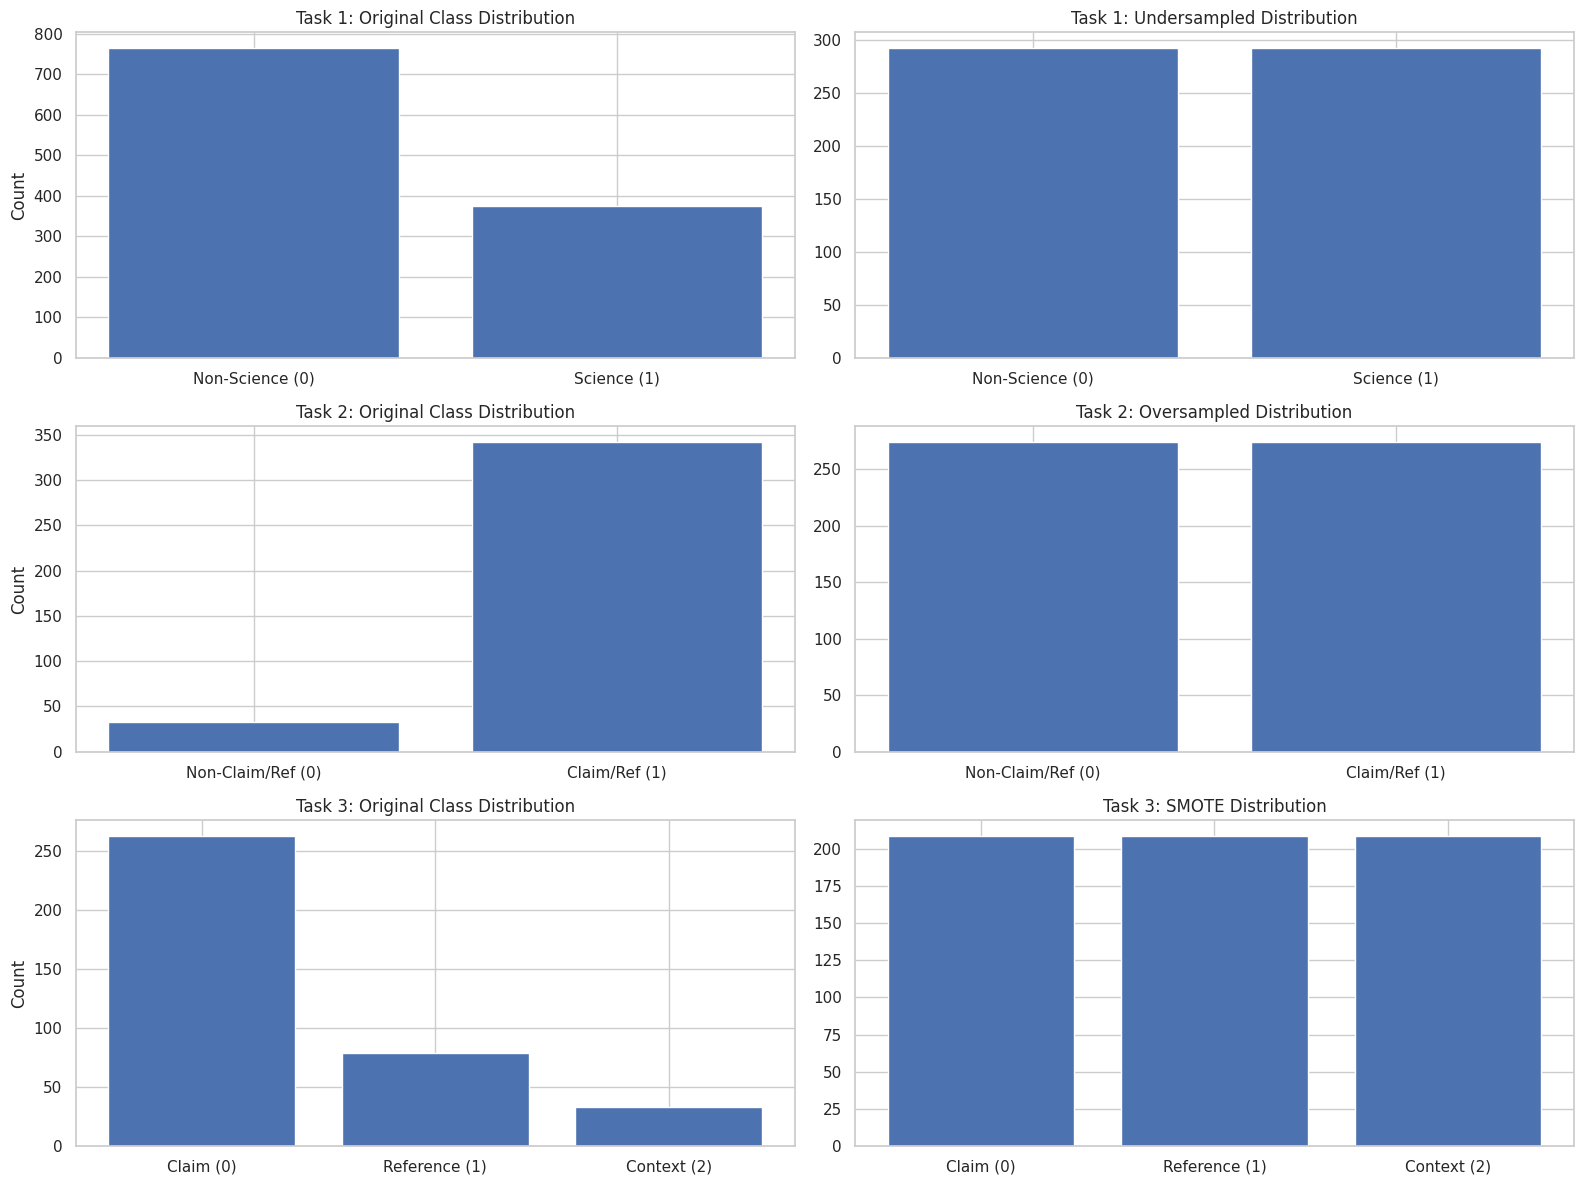

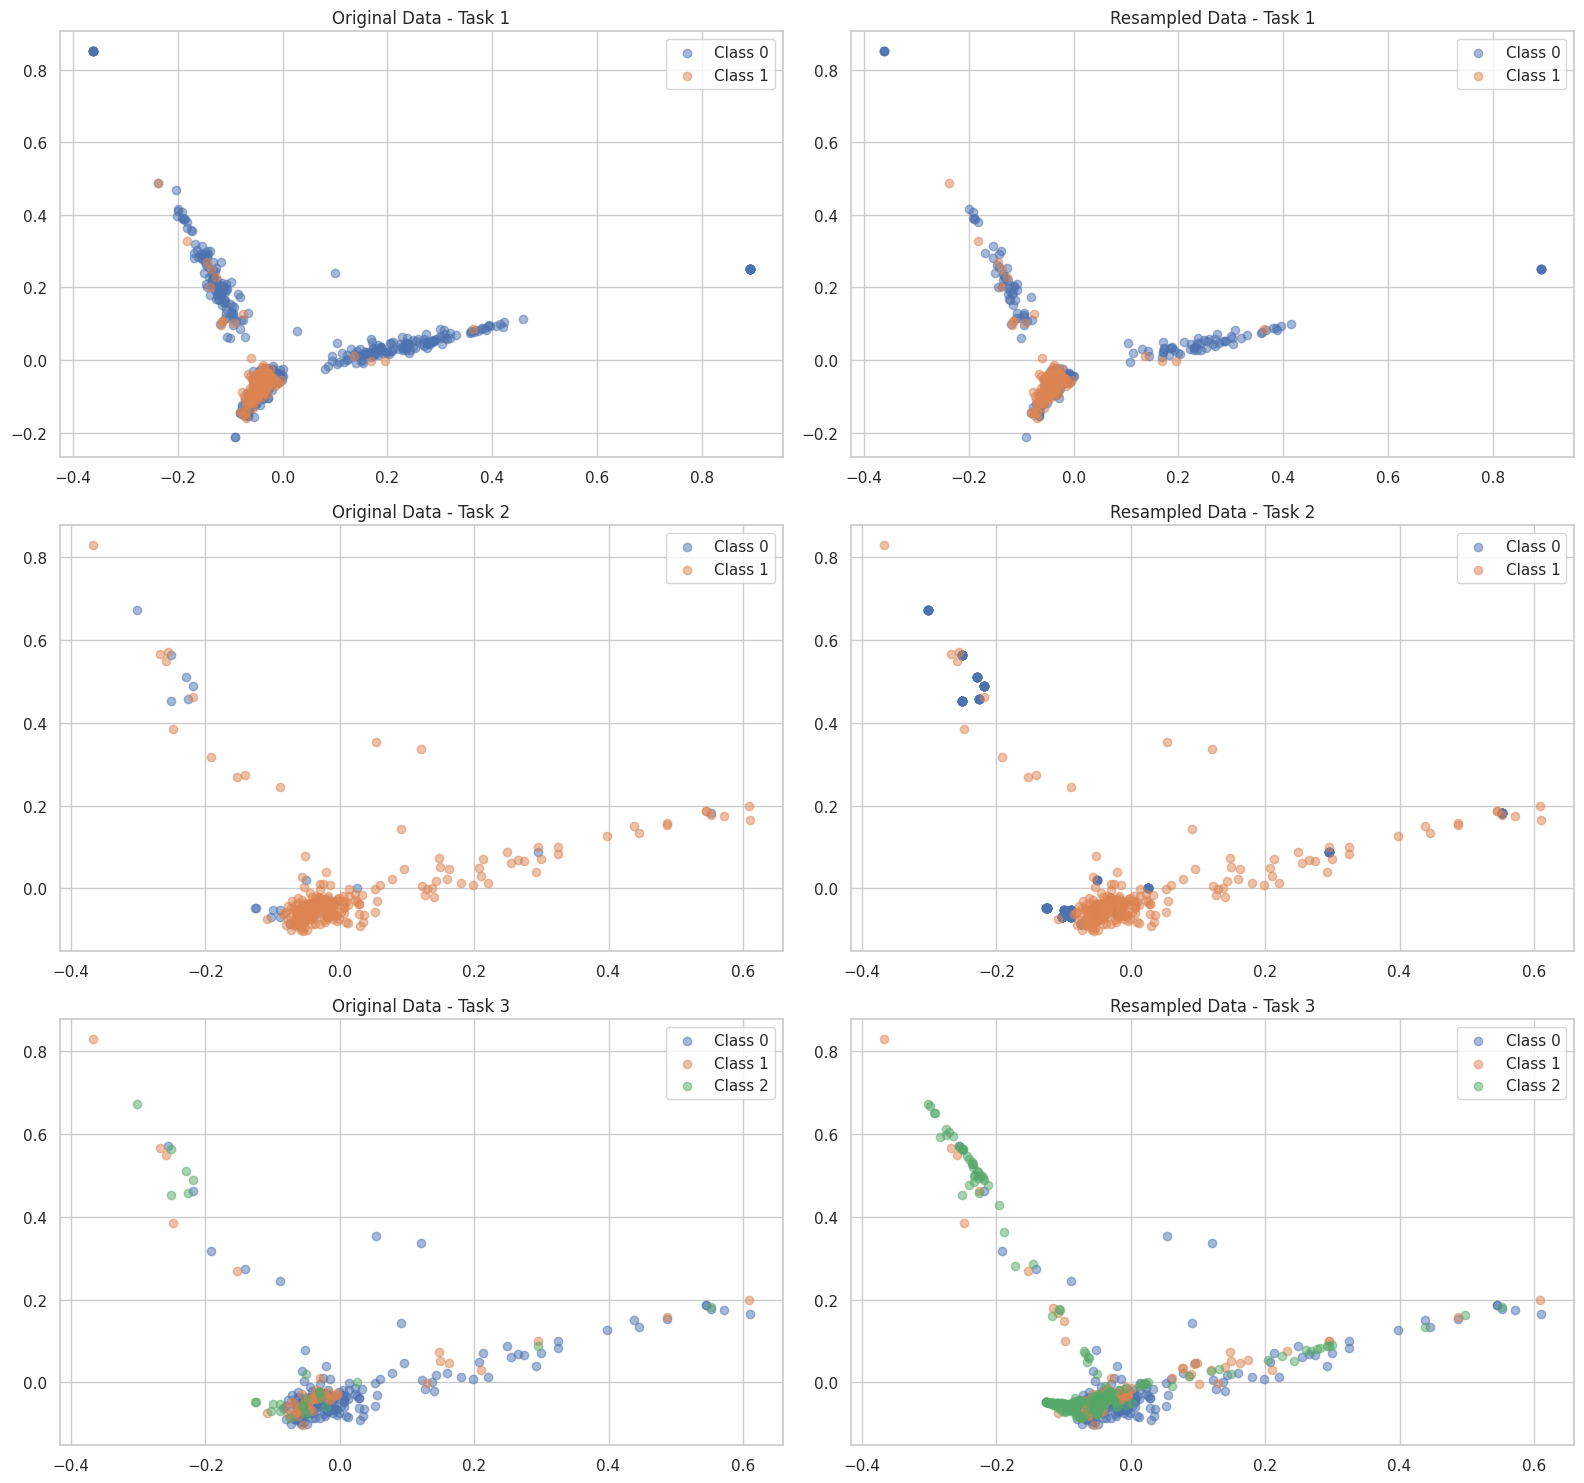

Analysis of Resampling Effects on Model Performance:
--------------------------------------------------
1. Task 1 (Undersampling) - Positive Impact:
   - Balanced classes improved minority class recognition
   - Simple binary classification benefited from equal representation
   - Removing majority samples reduced noise and improved decision boundaries

2. Task 2 (Oversampling) - Negative Impact:
   - Duplicating minority samples may have caused overfitting
   - The original imbalance was extreme (few non-claim/ref samples)
   - Model trained on artificial balance struggled with natural imbalance in test data

3. Task 3 (SMOTE) - Negative Impact:
   - Multi-class problem is more complex than binary classification
   - Synthetic samples may not capture the true distribution of feature space
   - SMOTE creates synthetic samples that may not represent realistic tweets
   - Some classes may have subtle differences that SMOTE couldn't replicate accurately

Recommendations for Improving Perf

In [47]:
from sklearn.decomposition import PCA

# Analysis: Why Resampling Performance Varies Across Tasks

# Let's visualize the class distributions before and after resampling for each task
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Task 1: Original vs Undersampled
axes[0, 0].bar(['Non-Science (0)', 'Science (1)'], df['task1_label'].value_counts().sort_index())
axes[0, 0].set_title('Task 1: Original Class Distribution')
axes[0, 0].set_ylabel('Count')

axes[0, 1].bar(['Non-Science (0)', 'Science (1)'], pd.Series(y_train_task1_under).value_counts().sort_index())
axes[0, 1].set_title('Task 1: Undersampled Distribution')

# Task 2: Original vs Oversampled
axes[1, 0].bar(['Non-Claim/Ref (0)', 'Claim/Ref (1)'], df_sci['task2_label'].value_counts().sort_index())
axes[1, 0].set_title('Task 2: Original Class Distribution')
axes[1, 0].set_ylabel('Count')

axes[1, 1].bar(['Non-Claim/Ref (0)', 'Claim/Ref (1)'], pd.Series(y_train_task2_over).value_counts().sort_index())
axes[1, 1].set_title('Task 2: Oversampled Distribution')

# Task 3: Original vs SMOTE
axes[2, 0].bar(['Claim (0)', 'Reference (1)', 'Context (2)'], df_sci['task3_label'].value_counts().sort_index())
axes[2, 0].set_title('Task 3: Original Class Distribution')
axes[2, 0].set_ylabel('Count')

axes[2, 1].bar(['Claim (0)', 'Reference (1)', 'Context (2)'], pd.Series(y_train_task3_smote).value_counts().sort_index())
axes[2, 1].set_title('Task 3: SMOTE Distribution')

plt.tight_layout()
plt.show()

# Analyze feature distributions before and after resampling

# Function to visualize data distributions in 2D
def plot_pca_distribution(X_orig, X_resampled, y_orig, y_resampled, title, ax1, ax2):
    # Apply PCA
    pca = PCA(n_components=2)
    X_orig_pca = pca.fit_transform(X_orig)
    X_resampled_pca = pca.transform(X_resampled)
    
    # Original data
    for class_val in np.unique(y_orig):
        idx = np.where(y_orig == class_val)[0]
        ax1.scatter(X_orig_pca[idx, 0], X_orig_pca[idx, 1], alpha=0.5, label=f'Class {class_val}')
    ax1.set_title(f'Original Data - {title}')
    ax1.legend()
    
    # Resampled data
    for class_val in np.unique(y_resampled):
        idx = np.where(y_resampled == class_val)[0]
        ax2.scatter(X_resampled_pca[idx, 0], X_resampled_pca[idx, 1], alpha=0.5, label=f'Class {class_val}')
    ax2.set_title(f'Resampled Data - {title}')
    ax2.legend()

# Create a figure for PCA visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 15))

# Task 1: Original vs Undersampled PCA visualization
plot_pca_distribution(X_train_task1, X_train_task1_under, y_train_task1, y_train_task1_under, 
                     'Task 1', axes[0, 0], axes[0, 1])

# Task 2: Original vs Oversampled PCA visualization
plot_pca_distribution(X_train_task2, X_train_task2_over, y_train_task2, y_train_task2_over,
                     'Task 2', axes[1, 0], axes[1, 1])

# Task 3: Original vs SMOTE PCA visualization
plot_pca_distribution(X_train_task3, X_train_task3_smote, y_train_task3, y_train_task3_smote,
                     'Task 3', axes[2, 0], axes[2, 1])

plt.tight_layout()
plt.show()

# Analysis: Why resampling might have led to worse performance in Task 2 and 3
print("Analysis of Resampling Effects on Model Performance:")
print("-" * 50)
print("1. Task 1 (Undersampling) - Positive Impact:")
print("   - Balanced classes improved minority class recognition")
print("   - Simple binary classification benefited from equal representation")
print("   - Removing majority samples reduced noise and improved decision boundaries")
print("\n2. Task 2 (Oversampling) - Negative Impact:")
print("   - Duplicating minority samples may have caused overfitting")
print("   - The original imbalance was extreme (few non-claim/ref samples)")
print("   - Model trained on artificial balance struggled with natural imbalance in test data")
print("\n3. Task 3 (SMOTE) - Negative Impact:")
print("   - Multi-class problem is more complex than binary classification")
print("   - Synthetic samples may not capture the true distribution of feature space")
print("   - SMOTE creates synthetic samples that may not represent realistic tweets")
print("   - Some classes may have subtle differences that SMOTE couldn't replicate accurately")
print("\nRecommendations for Improving Performance:")
print("1. For Task 1: Continue with undersampling or try combined techniques")
print("2. For Task 2: Consider cost-sensitive learning instead of resampling")
print("3. For Task 3: Try hierarchical classification or class-specific feature engineering")
print("4. For all tasks: Explore ensemble methods with different resampling ratios")